# Analyse Dsync Python Notebook

## Abstract

TODO

## Summary

TODO

In [165]:
#imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")
# sns.color_palette(palette="colorblind")

import scipy as sp
from scipy.stats import zscore
from scipy import signal
from scipy.signal import hilbert,hilbert2
# from scipy.ndimage import shift
from scipy.fft import fft,fftfreq
# from scipy.fftpack import *
import librosa
import librosa.display
import pycwt as wavelet #wavelet
import pywt
from dtw import *
from functools import partial
import itertools
from typing import Any, Dict, Optional, Tuple, Union
from typing_extensions import Self


from typing import Callable


import glob
import os
import sys
import pickle

import gc
import re

import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Audio, display, clear_output



def import_external():
    global Coherence,PeakDetect

    sys.path.insert(0, '../libs/python/SyncPy/src/')   # To be able to import packages from parent directory
    sys.path.insert(0, '../libs/python/SyncPy/src/Methods')
    sys.path.insert(0, '../libs/python/SyncPy/src/Methods/utils')  

    from DataFrom2Persons.Univariate.Continuous.Linear import Coherence

    import utils.Standardize
    from utils.ExtractSignal import ExtractSignalFromCSV
    from utils import PeakDetect,ConvertContinueToBinary

import_external()

## Build

Build DataFrame of datas, access and edit them

### glossary :

* data : where all datas (such as any type of files to proceed analysis) were stored
* exp : an experiment with some informations and datas
* trial : an trial of an experiment contening time series such as signal
* id : collection of information to indentify a trial 
* sig : signal time series
* onset : series of timecode
* sound : sound file

In [ ]:

MAIN_DATA_FOLDER = "../data/restart"
CLICK_TEMPO_FOLDER = "data-2023-09-26"
MASK_ATTACK_FOLDER = "data-2023-09-27"
CHANGE_FOLDER = "data-2023-09-28"

# Logics for my project

def trials_folder_to_sig_df(trial_folder : str) -> pd.DataFrame:

    def extract_trial_riot(filename):
        # trial_AnySTR-riot trial and str are int
        match = re.match(r'(\d+)_.*-(\d+)\.txt', filename)
        if match:
            trial, riot = match.groups()
            return int(trial), int(riot)
        else:
            return None, None

    def parse_file(filepath):
        data = []
        with open(filepath, 'r') as file:
            for line in file:
                values = line.split(' ')
                data.append(values)
        return data

    def create_dataframe(data, trial, riot):
        columns = [
            't', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z',
            'mag_x', 'mag_y', 'mag_z', 'orientation_x', 'orientation_y', 'orientation_z',
            'accfilt_x', 'accfilt_y', 'accfilt_z', 'intensity'
        ]
        df = pd.DataFrame(data, columns=columns)
        df = df.apply(pd.to_numeric, errors='coerce')
        df['trial_n'] = trial
        df['riot_n'] = riot
        return df


    all_data = []
    for filename in os.listdir(trial_folder):
        if filename.endswith(".txt"):
            trial, riot = extract_trial_riot(filename)
            if trial is not None and riot is not None:
                filepath = os.path.join(trial_folder, filename)
                data = parse_file(filepath)
                df = create_dataframe(data, trial, riot)
                all_data.append(df)
    
    compiled_df = pd.concat(all_data, ignore_index=True)
    return compiled_df
def infos_folder_to_complete_sig_df(info_folder : str,df : pd.DataFrame) -> pd.DataFrame:

    
    musicians_info_path = os.path.join(info_folder, 'riots-musicians.txt')
    musician_info = {}
    musician_riots = {}

    trials_info_path = os.path.join(info_folder, 'trials-info.txt')
    trials_info = {}

    # Load musician and riot info
    with open(musicians_info_path, 'r') as file:
        for line in file:
            riot_number, musician, riot_type = line.strip().split()
            musician_info[int(riot_number)] = (musician, riot_type)
            
           # musician already in dict
            if musician not in musician_riots:
                musician_riots[musician] = (None, None)
            
            if riot_type == 'head':
                musician_riots[musician] = (int(riot_number), musician_riots[musician][1])
            elif riot_type in ['arm', 'leg']:
                if musician_riots[musician][1] is None:
                    musician_riots[musician] = (musician_riots[musician][0], int(riot_number)-1)

     # Load trials info
    with open(trials_info_path, 'r') as file:
        n = 1
        for line in file:
            factors = line.strip().split()
            trials_info[n] = (tuple(factors))
            n += 1

    # Extract musician and riot_type from musician_info based on riot_n
    df['musician'] = df['riot_n'].map(lambda x: musician_info[x][0] if x in musician_info else None)
    df['riot_type'] = df['riot_n'].map(lambda x: musician_info[x][1] if x in musician_info else None)

    # Extract factor1 and factor2 from trials_info based on trial_n
    df['factor1'] = df['trial_n'].map(lambda x: trials_info[x][0] if x in trials_info else None)
    df['factor2'] = df['trial_n'].map(lambda x: trials_info[x][1] if x in trials_info else None)

    # change have a therd info : timecode of change prompt
    if len(trials_info[1]) > 2:
        df['change'] = df['trial_n'].map(lambda x: trials_info[x][2] if x in trials_info else None)

    return df

    return df

def onsets_folder_to_onset_df(onsets_folder : str) -> pd.DataFrame:

    def onset_csvname2musician(csvname):
        if("Pno" in csvname or "piano" in csvname):
            return "Piano"
        if("Sax" in csvname or "sax" in csvname):
            return "Sax"
        if("Vlc" in csvname or "cello" in csvname):
            return "Cello"
        if("MD" in csvname or "MG" in csvname):
            return "Accordion"
        if("Clar" in csvname):
            return "Clarinet"
        if("Tom" in csvname or "peau" in csvname or "OH" in csvname or "Snare" in csvname or "Kick" in csvname or "drums" in csvname):
            return "Drum"
        return None
        
    def extract_trial_number(csvname):
        match = re.match(r'(\d+)_.*\.csv', csvname)
        if match:
            return int(match.group(1))
        return None
    
    all_data = []

    for filename in os.listdir(onsets_folder):
        if filename.endswith(".csv"):
            filepath = os.path.join(onsets_folder, filename)
            trial_n = extract_trial_number(filename)
            musician = onset_csvname2musician(filename)

            if trial_n is not None and musician != "Unknown":
                df = pd.read_csv(filepath)
                df.rename(columns={'Absolute Time (s)': 'onsets'}, inplace=True)
                df['trial_n'] = trial_n
                df['musician'] = musician
                all_data.append(df)
            else:
                print('error reading trial and musician',trial_n,musician)

    compiled_df = pd.concat(all_data, ignore_index=True)
    compiled_df['onsets'] *= 1000.0 #convert s to ms
    return compiled_df
def infos_folder_to_complete_onset_df(info_folder : str,df : pd.DataFrame) -> pd.DataFrame:

    trials_info_path = os.path.join(info_folder, 'trials-info.txt')
    trials_info = {}

     # Load trials info
    with open(trials_info_path, 'r') as file:
        n = 1
        for line in file:
            factors = line.strip().split()
            trials_info[n] = (tuple(factors))
            n += 1

    # Extract factor1 and factor2 from trials_info based on trial_n
    df['factor1'] = df['trial_n'].map(lambda x: trials_info[x][0] if x in trials_info else None)
    df['factor2'] = df['trial_n'].map(lambda x: trials_info[x][1] if x in trials_info else None)
    # change have a therd info : timecode of change prompt
    if len(trials_info[1]) > 2:
        df['change'] = df['trial_n'].map(lambda x: trials_info[x][2] if x in trials_info else None)

    return df

def trunc_dfs(dfs: Dict[str, pd.DataFrame], truncs: Dict[Any, Tuple[Optional[float], Optional[float]]] = {None:(None, None)},**kwargs : Any) -> Dict[str, pd.DataFrame]:
    # always return a copy
    def trunc_mask(df, trunc_col, indexer_col, indexer, trunc_start, trunc_end):
        # Apply truncation mask if start and/or end is specified based on trunc_col following indexer rule
        mask = (df[indexer_col] == indexer)
        
        if trunc_start is not None:
            mask &= (df[trunc_col].astype(float) >= trunc_start)
            
        if trunc_end is not None:
            mask &= (df[trunc_col].astype(float) <= trunc_end)
        
        return mask

    sig_trunc_mask = pd.Series([False] * len(dfs['sig']))
    onset_trunc_mask = pd.Series([False] * len(dfs['onset']))

    for indexer, trunc_values in truncs.items():
        trunc_start, trunc_end = trunc_values

        # Update the mask for signal and onset DataFrames
        sig_trunc_mask |= trunc_mask(dfs['sig'], 't', 'trial_n', indexer, trunc_start, trunc_end)
        onset_trunc_mask |= trunc_mask(dfs['onset'], 'onsets', 'trial_n', indexer, trunc_start, trunc_end)

    # Create masks for rows where indexer_col values are not in truncs keys
    sig_not_in_truncs = ~dfs['sig']['trial_n'].isin(truncs.keys())
    onset_not_in_truncs = ~dfs['onset']['trial_n'].isin(truncs.keys())

    # Combine the masks to include all relevant data
    sig_combined_mask = sig_trunc_mask | sig_not_in_truncs
    onset_combined_mask = onset_trunc_mask | onset_not_in_truncs

    # Apply the masks to create truncated DataFrames
    sig_trunc : pd.DataFrame = dfs['sig'][sig_combined_mask].copy().reset_index(drop=True) # type: ignore
    onset_trunc : pd.DataFrame = dfs['onset'][onset_combined_mask].copy().reset_index(drop=True) # type: ignore

    return {'sig': sig_trunc, 'onset': onset_trunc}

#logic to create a filter's mask
def get_data_mask(df: pd.DataFrame, **kwargs: Any) -> pd.Series:
    # Start with a mask of all True values
    mask = pd.Series([True] * len(df))
    
    # Iterate over the keyword arguments to update the mask
    for key, value in kwargs.items():
        if key in df.columns and value is not None:
            mask &= (df[key] == value)
    
    return mask

def compiling_exp_to_df(    trial_folder : str,
                            info_folder : str,
                            trial_logic : Callable[[str],pd.DataFrame], 
                            info_logic :  Callable[[str,pd.DataFrame],pd.DataFrame]) -> pd.DataFrame:

    df = pd.DataFrame()

    #first construct df with signal/onset
    df = trial_logic(trial_folder)

    #complete df with id from info

    df = info_logic(info_folder,df)

    return df

#standalone function to filter a df
def get_data(df: pd.DataFrame, **kwargs : Any) -> pd.DataFrame:
    # Iterate over the keyword arguments to filter the DataFrame
    for key, value in kwargs.items():
        if key in df.columns and value is not None:
            # always return a copy with filter in function
            df = df.loc[df[key] == value].copy().reset_index(drop=True)
    
    return df

# TODO : make Dataset Generic ? (to also handle NdArray rather than Dataframe)
# Dataset is the class used to store data like input data, output data from compute or batch datas on a sort or trunc 
# user give to this class logics 
# Philosophy : Dataset containing RAW datas (untouched), every data coming out of a Dataset is a copy
class Dataset:
    def __init__(self,dataframes : Dict[str,pd.DataFrame] = {},trunc_logic : Callable = lambda x:x,exp_name : str = "") -> None:
        self.dataframes = dataframes
        self.exp_name = exp_name
        self.truncs = {}
        self.trunc_func = trunc_logic

    def load(self,path : str) -> Self:
        with open(path, 'rb') as file:
            data : Dataset = pickle.load(file)
            self.dataframes = data.dataframes
            self.exp_name = data.exp_name
            self.truncs = data.truncs
            self.trunc_func = data.trunc_func

        return self

    def save(self,path : str) -> None:
        #  with open(os.path.join(path,self.exp_name), 'wb') as file:
         with open(path, 'wb') as file:
            pickle.dump(self, file)
    
    def set_trunc(self,indexer : Any,trunc_values : Optional[Tuple[Optional[float],Optional[float]]] ) -> None:
        self.truncs.update({indexer:trunc_values})
    
    def get_truncate_dfs(self,**kwargs : Any) -> Dict[str,pd.DataFrame]:
        return self.trunc_func(self.dataframes,self.truncs)
    
    def add_df(self,df_key : str,df : pd.DataFrame)-> None:
        self.dataframes.update({df_key:df})

    def get_df(self,df_key:str) -> pd.DataFrame:
        if df_key not in self.dataframes:
                raise ValueError(f"Key '{df_key}' not found in Dataset {self.exp_name}.")
        return self.dataframes[df_key].copy()

    def build_add_df(self,df_key : str,build_logic : Callable[...,pd.DataFrame],*args : Any)-> None :
        self.add_df(df_key,build_logic(*args))

    def get_from_mask(self, mask_logic: Callable[..., pd.Series], **kwargs: Any) -> Dict[str, pd.DataFrame]:
        filtered_dataframes = {}
        for key, df in self.dataframes.items():
            mask = mask_logic(df, **kwargs)
            filtered_dataframes[key] = df[mask].copy().reset_index(drop=True)
        return filtered_dataframes
    
    def iterate_df(self, df_key: str, *keys: str):
        df = self.dataframes[df_key]
        # Ensure the keys are columns in the DataFrame
        for key in keys:
            if key not in df.columns:
                raise ValueError(f"Key '{key}' not found in DataFrame columns.")

        # Get unique values for each key
        key_values = [df[key].unique() for key in keys]
        
        # Iterate over all combinations of key values
        for combination in itertools.product(*key_values):
            mask = pd.Series([True] * len(df))
            for key, value in zip(keys, combination):
                mask &= (df[key] == value)
            subset = df[mask]
            if not subset.empty:
                yield combination, subset

    def iterate_dfs(self, *keys: str):
        key_values = {key: set() for key in keys}
        
        # Collect unique values for each key across all dataframes
        for df in self.dataframes.values():
            for key in keys:
                if key in df.columns:
                    key_values[key].update(df[key].unique())

        # Generate all combinations of key values
        all_combinations = list(itertools.product(*[key_values[key] for key in keys]))

        # Iterate over all combinations and yield corresponding DataFrame rows
        for combination in all_combinations:
            filtered_rows = {key: pd.Series() for key in self.dataframes.keys()}
            for df_key, df in self.dataframes.items():
                mask = pd.Series([True] * len(df))
                for key, value in zip(keys, combination):
                    if key in df.columns:
                        mask &= (df[key] == value)
                filtered_df = df[mask].copy().reset_index(drop=True)
                filtered_rows[df_key] = filtered_df
            yield combination, filtered_rows
    
    @staticmethod
    def build_df(build_logic : Callable[...,pd.DataFrame],*args : Any)-> pd.DataFrame :
        return build_logic(*args)

    @staticmethod
    #standalone function to filter a df
    def get_data(df: pd.DataFrame, **kwargs : Any) -> pd.DataFrame:
        # Iterate over the keyword arguments to filter the DataFrame
        for key, value in kwargs.items():
            if key in df.columns and value is not None:
                # always return a copy with filter in function
                df = df.loc[df[key] == value].copy().reset_index(drop=True)
        
        return df
    
folder = CLICK_TEMPO_FOLDER



## Plot

Functions to plot data

axe -> function -> axe

In [13]:
def plot_signal(x, y, ax=None, title=None, xlabel=None, ylabel=None, ylim=None, show=False, **plot_kwargs):
    """
    Plot a signal on a given axis.
    """
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x, y, **plot_kwargs)

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if ylim:
        ax.set_ylim(ylim)

    if show:
        plt.show()

    return ax

def plot_distribution(dataframe : pd.DataFrame,data_col:str,hue_cols:list[str],h_col:str,v_col:str,show:bool=False,**kwargs):
    
    # grouping hues
    hue_col = hue_cols[0]
    if len(hue_cols) > 1:
        dataframe = dataframe.copy()
        dataframe['hue_cols'] = dataframe[hue_cols].astype(str).apply(lambda row: ' '.join(row), axis=1)
        hue_col = 'hue_cols'

    hue_order = sorted(dataframe[hue_col].unique())

    grid = sns.catplot(dataframe,y=data_col,hue=hue_col,row=h_col,col=v_col,hue_order=hue_order,sharey=True,legend_out=True,**kwargs)
    
    if show:
        plt.show()

    return grid.axes_dict


In [ ]:

data = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_intensity.csv'))
onset = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_onset.csv'))

plot_distribution(data,'intensity',['factor1','factor2'],'riot_type','musician',show=True,kind='bar',errorbar=('se'))

dataset = Dataset()
dataset.add_df('sig',data)
dataset.add_df('onset',onset)





## Synth

Synthetic signal to modelise signal processing behavior

In [ ]:
%matplotlib widget
fs = 100  # Sampling frequency

class SynthSignal:
    def __init__(self, signal_type, amplitude, frequency=0.0, duty=0.5, decay=1.0, noise_level=0.0, fs=fs, duration=60, freq_variation_rate=0.0, freq_bounds=(0, 10), seed=None):
        self.signal_type = signal_type
        self.amplitude = amplitude
        self.frequency = frequency
        self.duty = duty
        self.decay = decay
        self.noise_level = noise_level
        self.fs = fs
        self.duration = duration
        self.freq_variation_rate = freq_variation_rate
        self.freq_bounds = freq_bounds
        self.seed = seed
        self.t, self.signal_wave = self._generate_signal()
        
    def _generate_signal(self):
        t = np.linspace(0, self.duration, int(self.fs * self.duration), endpoint=False)
        np.random.seed(self.seed)
        frequencies = np.full(t.shape, self.frequency)

        if self.frequency is not None and 0 < self.freq_variation_rate <= 1:
            num_random_values = int(len(t) * self.freq_variation_rate)
            random_indices = np.random.choice(len(t), size=num_random_values, replace=False)
            random_values = np.random.uniform(self.freq_bounds[0], self.freq_bounds[1], size=num_random_values)
            frequencies[random_indices] = random_values

        signal_wave = np.zeros_like(t)
        if self.signal_type == 'sine':
            i = 0
            cumulative_phase = 0
            while i < len(t):
                period_samples = int(self.fs / frequencies[i])
                if i + period_samples < len(t):
                    for j in range(period_samples):
                        if i + j < len(t):
                            phase_increment = 2 * np.pi * frequencies[i] / self.fs
                            signal_wave[i + j] = self.amplitude * np.sin(cumulative_phase)
                            cumulative_phase += phase_increment
                i += period_samples
        elif self.signal_type == 'square':
            i = 0
            while i < len(t):
                period_samples = int(self.fs / frequencies[i])
                high_samples = int(period_samples * self.duty)
                if i + period_samples < len(t):
                    signal_wave[i:i + high_samples] = self.amplitude
                    signal_wave[i + high_samples:i + period_samples] = 0
                i += period_samples
        elif self.signal_type == 'triangle':
            i = 0
            while i < len(t):
                period_samples = int(self.fs / frequencies[i])
                high_samples = int(period_samples * self.duty)
                low_samples = period_samples - high_samples
                if i + period_samples < len(t):
                    signal_wave[i:i + high_samples] = np.linspace(0, self.amplitude, high_samples)
                    signal_wave[i + high_samples:i + period_samples] = np.linspace(self.amplitude, 0, low_samples)
                else:
                    remaining_samples = len(t) - i
                    if remaining_samples <= high_samples:
                        signal_wave[i:i + remaining_samples] = np.linspace(0, self.amplitude, remaining_samples)
                    else:
                        signal_wave[i:i + high_samples] = np.linspace(0, self.amplitude, high_samples)
                        signal_wave[i + high_samples:len(t)] = np.linspace(self.amplitude, 0, remaining_samples - high_samples)
                i += period_samples
        elif self.signal_type == 'exponential':
            period_samples = self.fs / frequencies
            i = 0
            while i < len(t):
                period = int(period_samples[i])
                half_period = period // 2
                if i + period < len(t):
                    signal_wave[i:i + half_period] = self.amplitude * np.exp(-self.decay * np.linspace(0, 1, half_period))
                    signal_wave[i + half_period:i + period] = self.amplitude * np.exp(-self.decay * np.linspace(0, 1, period - half_period))[::-1]
                i += period
        else:
            raise ValueError("Unrecognized signal type")

        if self.noise_level > 0:
            noise = np.random.normal(0, self.noise_level, signal_wave.shape)
            signal_wave += noise

        return t, signal_wave
    
    def to_dataframe(self, dfname='signal'):
        return pd.DataFrame({'t': self.t, dfname: self.signal_wave})

    def to_ndarray(self):
        return np.array([self.t, self.signal_wave])


class SynthOnset:
    def __init__(self, amplitude=1.0, frequency=0.0, freq_variation_rate=0.0, freq_bounds=(0, 10), fs=fs, duration=60, seed=None):
        self.amplitude = amplitude
        self.frequency = frequency
        self.freq_variation_rate = freq_variation_rate
        self.freq_bounds = freq_bounds
        self.fs = fs
        self.duration = duration
        self.seed = seed
        self.t, self.onsets = self._generate_onset()

    def _generate_onset(self):
        t = np.linspace(0, self.duration, int(self.fs * self.duration), endpoint=False)
        np.random.seed(self.seed)
        frequencies = np.full(t.shape, self.frequency)

        if self.frequency is not None and 0 < self.freq_variation_rate <= 1:
            num_random_values = int(len(t) * self.freq_variation_rate)
            random_indices = np.random.choice(len(t), size=num_random_values, replace=False)
            random_values = np.random.uniform(self.freq_bounds[0], self.freq_bounds[1], size=num_random_values)
            frequencies[random_indices] = random_values

        onsets = []
        period_samples = self.fs / frequencies
        i = 0
        while i < len(t):
            onset_index = int(i)
            if onset_index < len(t):
                onsets.append(t[onset_index])
            i += int(period_samples[i])

        return t, np.array(onsets)

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame({'onsets': self.onsets})

    def to_ndarray(self):
        return self.onsets
    
    def to_signal(self, signal_t: Optional[np.ndarray] = None, value=1.0):
        onsets_df = self.to_dataframe()

        if onsets_df.empty:
            return None
        
        if signal_t is not None:
            duration = len(signal_t)  # samples
            signal_firstidx = round(signal_t[0] * self.fs)  # assuming signal_t is in seconds
        else:
            duration = int(self.duration * self.fs)
            signal_firstidx = 0
        
        signal = np.zeros(duration)
        
        for idx in onsets_df['onsets']:
            onset_index = round(idx * self.fs) - signal_firstidx
            if 0 <= onset_index < duration:
                signal[onset_index] = value
        
        return signal



## Analyse

Utilities to analyse dsync

### Signal

Signal processing functions

In [129]:
from asyncio import wait
from collections import deque


def advanced_cfd_autoperiod(sig : np.ndarray,iter_perm  : int = 100,adjust_treshold :int = 0,tolerance : float = 0.2,w_threshold_rate : float = 1/3,
                            fs  : int = 100,nperseg  : int = 2192,noverlap  : int = 2048 ,nfft : int = 8192,psd_window_type  : str = 'hamming',debug : bool = False)-> list[Dict]:

    """
    Advanced Clustered Filtered Detrended Autoperiod determines the frequencies and amplitudes that compose a signal
    by comparing the Fourier Transform, Power Spectral Density (PSD), and the detrended autocorrelation of the filtered signal
    over each period interval of each potential frequency.

    ## Parameters:
    * sig (np.ndarray): The input signal to be analyzed.
    * iter_perm (int): The number of iterations to find the threshold.
    * adjust_treshold (int): An integer value between [-iter_perm, iter_perm] to adjust the threshold during the iterations.
    * tolerance (float): The frequency tolerance used for clustering the hints and validating a hint.
    * w_threshold_rate (float) : The minimum rate of hint redundancy through the signal to be validate
    * fs (int): The sampling frequency of the signal.
    * nperseg (int): The number of samples per segment for calculating the PSD.
    * noverlap (int): The number of samples that overlap between segments for the PSD calculation.
    * nfft (int): The total number of samples taken for the threshold calculation and the PSD.
    * psd_window_type (str): The type of window used for calculating the PSD. Refer to scipy's window types.
    * debug (bool): If set to True, the function will display debugging graphs of the algorithm.

    ## Returns:
    List[Dict]: A list of dictionaries, where each dictionary contains:
        - frequency: The frequency of the hint.
        - amplitude: The amplitude of the hint.
        - power: The square root of the power of the hint.
        - centroid: The spectral centroid of the cluster.
        - range: The frequency interval of the power.
        - weight : redundancy rate of the hint (higher is better)
    """

    def _acfda_find_treshold(sig : np.ndarray,fs,nfft = 8192,iter_perm = 100) -> list[float]:
        sig_p = np.ndarray(sig.shape)
        _max = 0
        max_psd : list[float] = []
        for i in range(iter_perm):
            np.random.seed()
            sig_p = np.random.permutation(sig)
            _max = np.max(np.sqrt(signal.welch(sig_p, fs=fs, nperseg=sig.size,nfft=nfft,noverlap=sig.size - 1,scaling='spectrum',average='mean',window='hamming')[1]))
            max_psd.append(_max)
        max_psd.sort()
        # return 2*max_psd[0]-max_psd[-1] # return max_psd[-1] but I want a lower baseline ton ensure to get low amplitude
        return max_psd

    def _acfda_find_peaks(sig : np.ndarray, threshold : float,fs,tolerance = 0.05,nperseg = 2192,noverlap=2190,nfft=8192,psd_window_type='hamming',debug = False ):
        # Perform FFT
        fft_freqs,fft_amplitudes = dft(sig,fs)
        fft_res = fft_freqs[1] - fft_freqs[0]
        
        # Perform Welch PSD
        frequencies, psd = signal.welch(sig, fs=fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap, scaling='spectrum',average='mean',window=psd_window_type)
        psd_sqrt = np.sqrt(psd)
        frequency_res = fft_res # maximal frequency resolution to estimate welch lobe
        
        # Find peaks in FFT above threshold
        peaks, _ = signal.find_peaks(fft_amplitudes, height=threshold)

        # find where sqrt psd cross treshold
        idx =  np.where(np.diff(np.sign(psd_sqrt - threshold)))[0]
        idx_adjust = []
        # Prefer the index where the value is under the threshold
        for idx in idx:
            while idx < len(psd_sqrt) and psd_sqrt[idx] > threshold:
                idx += 1
            idx_adjust.append(idx)


        # Prepare hints
        hints = []
        clusters = []
        cluster = []


        # find first true potential peak
        for peak in peaks:
            f_peak = fft_freqs[peak]
            a_peak = fft_amplitudes[peak]
            power_peak = psd_sqrt[np.argmin(np.abs(frequencies - fft_freqs[peak]))]
            welch_range = [None,None]
            # avoid fake positive
            if (power_peak < threshold):
                    continue
            else : break
        

        # Find range in Welch PSD
        welch_xzero_f = frequencies[idx_adjust]
        
        mask_left = welch_xzero_f < f_peak
        mask_right = welch_xzero_f > f_peak

        if np.any(mask_left):
            left_value = np.max(welch_xzero_f[mask_left])
        else:
            left_value = None

        if np.any(mask_right):
            right_value = np.min(welch_xzero_f[mask_right])
        else:
            right_value = None

        welch_range = [left_value, right_value]

        cluster.append({
                'frequency': f_peak,
                'amplitude': a_peak,
                'power': power_peak,
                'range': welch_range
                })
        
        e = fft_freqs[peak] + frequency_res + tolerance

        for peak in peaks[1:]:
            f_peak = fft_freqs[peak]
            a_peak = fft_amplitudes[peak]
            power_peak = psd_sqrt[np.argmin(np.abs(frequencies - fft_freqs[peak]))]
            welch_range = [None,None]

            #fake positive
            if (power_peak < threshold):
                continue
            
            # Find range in Welch PSD
            welch_xzero_f = frequencies[idx_adjust]
            
            mask_left = welch_xzero_f < f_peak
            mask_right = welch_xzero_f > f_peak

            if np.any(mask_left):
                left_value = np.max(welch_xzero_f[mask_left])
            else:
                left_value = None

            if np.any(mask_right):
                right_value = np.min(welch_xzero_f[mask_right])
            else:
                right_value = None

            welch_range = [left_value, right_value]

            
            # Density Clustering
            # to close and same welch range TODO this last can be problematic for a low treshold and avoid true peak
            previous_welch_range = cluster[-1]['range']
            if(f_peak <= e and (previous_welch_range[0] == welch_range[0] and previous_welch_range[1] == welch_range[1])):
            # if(f_peak <= e ):
                # same welch range

                cluster.append({
                'frequency': f_peak,
                'amplitude': a_peak,
                'power': power_peak,
                'range': welch_range
                })
                e = fft_freqs[peak] + frequency_res + tolerance


            else:
                clusters.append(cluster)
                cluster = []
                cluster.append({
                'frequency': f_peak,
                'amplitude': a_peak,
                'power': power_peak,
                'range': welch_range
                })
                e = fft_freqs[peak] + frequency_res + tolerance

        # last cluster
        if cluster:
            clusters.append(cluster)
        
        if debug : 
            _, ax = plt.subplots( figsize=(12, 6))
            plot_signal(fft_freqs,fft_amplitudes,ax=ax,color='red',label='dft')
            plot_signal(frequencies,psd_sqrt,ax=ax,color='green',label='sqrt of psd')
            ax.axhline(threshold,color='black',linestyle='--',label='treshold')

            for peak in peaks:
                peak_idx = np.argmin(np.abs(frequencies - fft_freqs[peak]))
                ax.plot(fft_freqs[peak],fft_amplitudes[peak], 'ro',label='frequency peak')
                ax.plot(frequencies[peak_idx],psd_sqrt[peak_idx], 'gx',label='power peak')

            for i in idx_adjust:
                ax.plot(frequencies[i],psd_sqrt[i], 'bo',label='power range')

            ax.set_xscale('log')
            plt.tight_layout()

        # cluster selection : use queue to avoid unexcepted behavior
        queue = deque(clusters)
        while queue:
            cluster = queue.popleft()

            max_amp_peak : Dict = max(cluster, key=lambda x: x['amplitude'])

            max_peak = max(cluster, key=lambda x: x['frequency'])
            min_peak = min(cluster, key=lambda x: x['frequency'])

            #compute centroids
            indx = np.where((fft_freqs >= min_peak['frequency']) & (fft_freqs <= max_peak['frequency']))[0]
            if len(indx):
                freqs_in_range = fft_freqs[indx]
                amps_in_range = fft_amplitudes[indx]
                centroid = np.sum(freqs_in_range * amps_in_range) / np.sum(amps_in_range)
            else:
                centroid = max_amp_peak['frequency']

            # solves the problem of close lobes
            if(abs(max_amp_peak['frequency']-centroid) > tolerance):
                near_lobes = [
                    x for x in cluster
                    if abs(frequencies[np.argmin(np.abs(frequencies - fft_freqs[np.argmin(np.abs(fft_freqs - x['frequency']))]))] - centroid) <= tolerance
                ]
                max_power_peak_near_centroid = max(near_lobes, key=lambda x: x['power'])

                if debug :print('new cluster ->',max_power_peak_near_centroid['frequency'])

                # add to re iterate hint
                queue.append([max_power_peak_near_centroid]) 

            max_amp_peak.update({'centroid' : centroid})

            hints.append(max_amp_peak)

            if debug : 
                ax.plot(max_amp_peak['frequency'],max_amp_peak['amplitude'], 'y*',label="dominent cluster's peak")
                ax.axvline(max_amp_peak['centroid'],color='maroon',linestyle=':',linewidth=0.5,label='cluster centroid')

        if debug :
            plt.show()


        return hints

    def _acfda_validate_hint(x,y,hint,k_period=0,debug=False):
        # find kth range of periodicity
        period = 1/hint
        hint_range =  [(k_period * period + period / 2),((k_period + 1) * period + period / 2)]
        idx = np.where((x >= hint_range[0]) & (x <= hint_range[1]))

        # plot_signal(x,y,show=True)

        x_range = x[idx]
        y_range = y[idx]

        # _max = x[idx][np.argmax(y[idx])]
        # print("max : " + str(_max))

        # fit a quadratic function

        nb_polynome = 2

        # Fit the polynomial
        coeffs = np.polyfit(x_range, y_range, nb_polynome)
        polynomial = np.poly1d(coeffs)

        # Compute the derivative of the polynomial
        polynomial_derivative = np.polyder(polynomial)

        # Evaluate the derivative over a fine grid within the same range
        x_der = x.copy()
        y_der = polynomial_derivative(x_der)
        
        # Find where the derivative changes sign
        sign_changes = np.where(np.diff(np.sign(y_der)))[0]

        sign_in_interval : bool = len(np.where((x_der[sign_changes] >= hint_range[0]) & (x_der[sign_changes] <= hint_range[1]))[0]) > 0
        negative_coeff : bool = (np.sign(coeffs[0]) < 0)

        # print(np.sign(coeffs[0]), np.where((x_der[sign_changes] >= hint_range[0]) & (x_der[sign_changes] <= hint_range[1]))[0] )

        if debug :
            fig, ax = plt.subplots( figsize=(12, 6))
            ax.set_xlim(x_range[0],x_range[-1])
            ax.set_ylim(-1,1)
            plot_signal(x,np.polyval(coeffs, x),ax=ax,color="green",linestyle="--",label='quadratic fit')
            plot_signal(x_der,y_der,ax=ax,color='y',linestyle='-.',label='derivative of fit')
            for s in sign_changes:
                ax.plot(x_der[s],y_der[s],"ro",label='sign change')
            plot_signal(x,y,ax=ax,color='b',label='autocorrelation')
            plot_signal(x_range,y_range,ax=ax,label='autocorrelation')
            plt.tight_layout()
            plt.show()

        return negative_coeff and sign_in_interval

    # TODO validation_window_type for better accuracy when filtering

    res = []
    # compute tresholds
    thresholds = _acfda_find_treshold(sig,fs=fs,iter_perm=iter_perm)
    
    # if abs(adjust_treshold)-1 > iter_perm-1 : adjust_treshold =  iter_perm-1
    # if abs(adjust_treshold)-1 < -(iter_perm-1) : adjust_treshold =  -(iter_perm-1)

    threshold = thresholds[0] + np.sign(adjust_treshold) * abs(thresholds[abs(adjust_treshold)-1]-thresholds[0])
    if threshold < 0 : threshold = 1E-5

    # hints detect
    # hints = _acfda_find_peaks(sig,threshold[-1],fs=fs,nperseg=nperseg,noverlap=noverlap,nfft=nfft,psd_window_type=psd_window_type,debug=debug)
    hints = _acfda_find_peaks(sig,threshold,fs=fs,nperseg=nperseg,tolerance=tolerance,noverlap=noverlap,nfft=nfft,psd_window_type=psd_window_type,debug=debug)

    # Sorting the list of dictionaries by 'frequency' in ascending order
    hints = sorted(hints, key=lambda x: x['frequency'])
    # hints = sorted(hints, key=lambda x: x['frequency'],reverse=True)

    _debug = debug
    debug = False

    for hint in range(len(hints)):
        # hints frequencies filtering
        hintf = hints[hint]['frequency']

        # high frequencies : itered through a low pass
        cutoff = hintf + 1.0/fs  + tolerance # next frequency bin with some tolerance
        # TODO CAUTION Need to be validate before filter ?!
        if (hint == 0): filtered_sig = sos_filter(sig ,sos_butter_lowpass(cutoff,fs)) # first : low pass
        elif (hint > len(hints)-2): filtered_sig = sig # last : nothing
        else : filtered_sig = sos_filter(sig ,sos_butter_lowpass(cutoff,fs))
        # else : filtered_sig = sos_filter(sig ,sos_butter_bandpass(hints[hint-1]['frequency'],hints[hint+1]['frequency'],fs)) # band

        # if (hint == 0 or len(res) == 0): filtered_sig = sig # first : nothing
        # if (hint == 0 or len(res) == 0): filtered_sig = sos_filter(sig ,sos_butter_lowpass(hintf,fs))
        # else : filtered_sig = sos_filter(sig ,sos_butter_lowpass(res[-1]['frequency'] + 1.0/fs  + tolerance,fs)) #  low pass

        # low frequencies : detrend autocorrelation
        autoc_x,autoc_y = autocorrelation(filtered_sig,lag_seconde=True)
        # interval = (1/(hintf - 1/fs + tolerance) ) # next frequency bin with some tolerance to period
        period = 1/(hintf - 1/fs + tolerance)

        max_period = int(round(hintf*autoc_x[-1] + 1/2)) - 1
        nb_validate = 0

        for k_period in range(max_period):
            #detrend auto-correlation on the kth period
            hint_range =  [(k_period * period + period / 2),((k_period + 1) * period + period / 2)]

            mask = np.where((autoc_x >= hint_range[0]) & (autoc_x <= hint_range[1]))[0]
            last_idx = mask[-1]
            autoc_interval_x = autoc_x[mask]
            autoc_interval_y = autoc_y[mask]
            coeffs = np.polyfit(autoc_interval_x, autoc_interval_y, 1)
            trend = np.poly1d(coeffs)(autoc_x)
            autoc_detrend_y = autoc_y - trend
    
            if debug :
                fig, ax = plt.subplots( figsize=(12, 6))
                ax.set_xlim(autoc_x[0],autoc_x[mask[-1]])
                ax.set_ylim(-1,1)
                plot_signal(autoc_x,autoc_y,ax=ax,color="blue",label='autocorrelation')
                plot_signal(autoc_interval_x,autoc_interval_y,ax=ax,color="red")
                plot_signal(autoc_x,trend,ax=ax,color="red",linestyle="--")
                plot_signal(autoc_x,autoc_detrend_y,ax=ax,color="green")
                # plot_signal(autoc_x,autoc_detrend_y2,ax=ax,color="pink")
                plt.show()

                # hints validation
            if _acfda_validate_hint(autoc_x,autoc_detrend_y,hintf,k_period=k_period,debug=debug): 
                # print('f',hintf,'period',k_period,"validate")
                nb_validate += 1
                # res.append(hints[hint])
            # else :
                # print('f',hintf,'period',k_period,"not validate")

            # if nb_validate >= nb_period_to_validate: 
            #     print('f',hintf,"validate")
            #     res.append(hints[hint])
            #     break

        w = nb_validate/max_period
        hints[hint].update({'weight':w})

        if w >= w_threshold_rate : 
            print('f:',hintf,"validate")
            res.append(hints[hint])
        else:
            print('f:',hintf,"not validate")

    if _debug:
        plt.figure(figsize=(12, 6))
        plt.title("Frequencies and Amplitudes with Power Curves")

        # Itérer sur les hints pour afficher les résultats
        for hint in res:
            freq = hint['frequency']
            amplitude = hint['amplitude']
            power_sqrt = hint['power']
            centroid = hint['centroid']
            freq_range = hint['range']
            weight = hint['weight']
            
            
            l = plt.stem(freq, amplitude, linefmt='red', markerfmt='.')  
            plt.setp(l, 'alpha', weight)
            plt.text(freq, amplitude, f'{freq} Hz', fontsize=12, ha='center')
            plt.axvline(centroid,color='maroon',linestyle=':',linewidth=0.5,label='cluster centroid')


            window = signal.get_window(psd_window_type, nfft)
            power_curve = power_sqrt * window
            x = np.linspace(freq_range[0], freq_range[1], nfft)
            y =  power_curve
            
            plt.plot(x, y, 'g--', alpha=0.7)

        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.xscale('log')
        plt.xlim(1E-2,50)
        plt.show()

    return res

fs = 100

def dft(sig,fs=100):
    N = len(sig)
    yf = fft(sig)
    xf = fftfreq(N, 1 / fs)

    # Conserver uniquement la partie positive du spectre
    pos_indices = xf >= 0
    xf = xf[pos_indices]
    yf = np.abs(yf)[pos_indices] * 2/N # type: ignore # Absolute amplitude and normalize with 2/len(sig) to get the right amps

    return xf,yf

def autocorrelation(sig,lag_seconde=False,norm=True,fs=100) -> tuple[np.ndarray,np.ndarray]:
    autocorr = np.correlate(sig, sig,mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Conserver seulement la moitié positive
    lags = np.arange(autocorr.size)
    if lag_seconde : lags = lags / fs  # Convertir les lags en secondes
    # Normaliser l'autocorrélation par la première valeur (=1)
    if norm : autocorr /= autocorr[0]
    return lags,autocorr

def sos_butter_highpass(cutoff,fs=fs,order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return signal.butter(order,normal_cutoff,'high',output='sos')
def sos_butter_lowpass(cutoff,fs=fs,order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return signal.butter(order,normal_cutoff,'low',output='sos')
def sos_butter_bandpass(lowcut, highcut, fs=fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return signal.butter(N=order, Wn=[low, high],btype='band', output='sos')

def sos_filter(data,sos):
    return signal.sosfiltfilt(sos, data)

def center_sig(data):
    return (data - data.mean()).copy()

def apodize(sig, window_size, fs, window_type='taylor'):
    """
    Apodize the given signal using a specified window type.

    Parameters:
    signal (numpy array): The input binary signal.
    window_size (float): The size of the window in seconds.
    fs (int): The sampling frequency in Hz.
    window_type (str): The type of window to use ('gaussian', 'hann', 'hamming', 'blackmanharris',
                                                  'exponential', 'chebwin', 'flattop', 'kaiser', 'nuttall', 'taylor').

    Returns:
    numpy array: The apodized signal.
    """
    if window_size == 0:
        return sig
    # Convert window size from seconds to samples
    window_width = int(window_size * fs)
    
    # Create the specified window
    if window_type == 'gaussian':
        window = signal.windows.gaussian(window_width, std=window_width/6)
    elif window_type == 'hann':
        window = signal.windows.hann(window_width)
    elif window_type == 'hamming':
        window = signal.windows.hamming(window_width)
    elif window_type == 'blackmanharris':
        window = signal.windows.blackmanharris(window_width)
    elif window_type == 'exponential':
        window = signal.windows.exponential(window_width, center=None, tau=window_width/6)
    elif window_type == 'chebwin':
        window = signal.windows.chebwin(window_width, at=100)
    elif window_type == 'flattop':
        window = signal.windows.flattop(window_width)
    elif window_type == 'kaiser':
        window = signal.windows.kaiser(window_width, beta=14)
    elif window_type == 'nuttall':
        window = signal.windows.nuttall(window_width)
    elif window_type == 'taylor':
        window = signal.windows.taylor(window_width, nbar=4, sll=100)
    elif window_type == 'cosine':
        window = signal.windows.cosine(window_width)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")
    
    # Find the indices where the signal has onsets (different than 0)
    # onset_indices = np.where(sig != 0)[0]
    
    # # Create a copy of the signal to apply the apodization
    # apodized_signal = np.copy(sig)
    
    # # Apply the specified window around each onset
    # for idx in onset_indices:
    #     start = max(0, idx - window_width//2)
    #     end = min(len(sig), idx + window_width//2)
    #     # apodized_signal[start:end] = np.maximum(apodized_signal[start:end], window[:end-start])
    #     apodized_signal[start:end] += apodized_signal[start:end] * window

    apodized_signal = np.convolve(sig,window,mode='same')
    
    return apodized_signal


def correlation(sig1,sig2,lag_seconde=False,norm=True):
    corr = np.correlate(sig1, sig2,mode='full')
    corr = corr[corr.size // 2:]  # Conserver seulement la moitié positive
    lags = np.arange(corr.size)
    if lag_seconde : lags = lags / fs  # Convertir les lags en secondes
    # Normaliser la corrélation
    if norm :
        sumsig1 = 0
        sumsig2 = 0
        for s1 in sig1 :
            sumsig1 += (s1 - sig1.mean())**2
        for s2 in sig2 :
            sumsig2 += (s2 - sig2.mean())**2
        corr /= np.sqrt(sumsig1 * sumsig2)

    return lags,corr

def shift(arr, num, fill_value):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def dwt_alignement(sig1,sig2):
    alignment = dtw(sig1,sig2,keep_internals=True)
    slope, intercept = np.polyfit(alignment.index1, alignment.index2, 1)

    x_fit = np.linspace(alignment.index1.min(), alignment.index1.max(), alignment.index1.size)
    y_fit = slope * x_fit + intercept

    # tolerance = 100.0 # ou 50.0 basé sur la résolution fréquentiel
    # within_tolerance = np.abs(alignment.index2 - y_fit) <= tolerance
    # alignement_rate = np.sum(within_tolerance) / len(alignment.index2) * 100   # pourcentage des points en dehors de la courbe (avec une tolérnce)

    sst = np.sum((alignment.index2 - np.mean(alignment.index2))**2)
    sse =  np.sum((alignment.index2 - y_fit)**2)
    ssr = np.sum((y_fit - np.mean(y_fit))**2)

    # alignement_rate = (1 - sse/sst) * 100 # coefficient de détermination R2
    alignement_rate = ssr/sst

    return (alignment.index1,alignment.index2), slope, alignement_rate

### Stats

Statistics functions

### Core

Main core to produce dataframe to analyse desynchronisation

#### Static

Static Descriptors of datas

#### Dynamic

Dynamic Descriptors of datas

#### Categorical

Categorise datas

## Tools

Widget to experiment 

## SandBox and TODO

Test Zone

In [10]:
# test advanced CFD-Autoperiod

import random

from numpy import sign


seed = random.randint(0,1000)

fo = 1/3

fa = 1/3
fb = 2/3
fe = 1
fc = 4
fd = 8
ff = 1/3 - 1/60

df = 1/25
f_rate = 0.9

# sine_signal = SynthSignal('sine', amplitude=0.05, frequency=fa, noise_level=0.0, freq_variation_rate=f_rate, freq_bounds=(fa - df, fa + df), seed=seed)
# sine1_signal = SynthSignal('sine', amplitude=0.05, frequency=ff, noise_level=0.0, freq_variation_rate=f_rate, freq_bounds=(ff - df, ff + df), seed=seed)
# sine2_signal = SynthSignal('sine', amplitude=0.05, frequency=fb, noise_level=0.00, freq_variation_rate=f_rate, freq_bounds=(fb - df, fb + df), seed=seed)
# sine3_signal = SynthSignal('sine', amplitude=0.05, frequency=fc, noise_level=0.00001, freq_variation_rate=f_rate, freq_bounds=(fc - df, fc + df), seed=seed)
# sine4_signal = SynthSignal('sine', amplitude=0.05, frequency=fd, noise_level=0.000, freq_variation_rate=f_rate, freq_bounds=(fd - df, fd + df), seed=seed)
# sine5_signal = SynthSignal('square', amplitude=0.01, frequency=fe, duty=0.5,noise_level=0.001, freq_variation_rate=0.001, freq_bounds=(fe - df, fe + df), seed=seed)

# sine_signal = SynthSignal('sine', amplitude=0.05, frequency=fa, noise_level=0.0, freq_variation_rate=f_rate, freq_bounds=(fa - df, fa + df), seed=seed)

sine_signal = SynthSignal('sine', amplitude=0.012, frequency=fa, noise_level=0.0, freq_variation_rate=f_rate, freq_bounds=(fa - df, fa + df), seed=seed)
sine1_signal = SynthSignal('sine', amplitude=0.005, frequency=ff, noise_level=0.0, freq_variation_rate=f_rate, freq_bounds=(abs(ff - df), ff + df), seed=seed)
sine2_signal = SynthSignal('sine', amplitude=0.01, frequency=fb, noise_level=0.00, freq_variation_rate=f_rate, freq_bounds=(fb - df, fb + df), seed=seed)
sine3_signal = SynthSignal('sine', amplitude=0.005, frequency=fc, noise_level=0.00001, freq_variation_rate=f_rate, freq_bounds=(fc - df, fc + df), seed=seed)
sine4_signal = SynthSignal('sine', amplitude=0.005, frequency=fd, noise_level=0.000, freq_variation_rate=f_rate, freq_bounds=(fd - df, fd + df), seed=seed)
sine5_signal = SynthSignal('sine', amplitude=0.01, frequency=fe, duty=0.5,noise_level=0.001, freq_variation_rate=0.001, freq_bounds=(fe - df, fe + df), seed=seed)

# sine5_signal = SynthSignal('square', amplitude=0.0, frequency=fe, duty=0.5,noise_level=0.001, freq_variation_rate=0.001, freq_bounds=(fe - df, fe + df), seed=seed)

# sine_signal = SynthSignal('sine', amplitude=0.012, frequency=1/3, noise_level=0.0, freq_variation_rate=0, freq_bounds=(fa - df, fa + df), seed=seed)
# sine1_signal = SynthSignal('sine', amplitude= 0.05, frequency=1/20, noise_level=0.0, freq_variation_rate=0, freq_bounds=(abs(ff - df), ff + df), seed=seed)
# sine2_signal = SynthSignal('sine', amplitude=0.0, frequency=fb, noise_level=0.00, freq_variation_rate=0, freq_bounds=(fb - df, fb + df), seed=seed)
# sine3_signal = SynthSignal('sine', amplitude=0.00, frequency=fc, noise_level=0.000, freq_variation_rate=0, freq_bounds=(fc - df, fc + df), seed=seed)
# sine4_signal = SynthSignal('sine', amplitude=0.00, frequency=fd, noise_level=0.000, freq_variation_rate=0, freq_bounds=(fd - df, fd + df), seed=seed)
# sine5_signal = SynthSignal('square', amplitude=0.0, frequency=fe, duty=0.5,noise_level=0., freq_variation_rate=0.0, freq_bounds=(fe - df, fe + df), seed=seed)

combined_signal_wave = sine_signal.signal_wave + sine1_signal.signal_wave + sine2_signal.signal_wave +  sine3_signal.signal_wave + sine4_signal.signal_wave + sine5_signal.signal_wave 


combined_signal_array = np.array([sine_signal.t, combined_signal_wave])

def _acfda_find_treshold(sig : np.ndarray,fs,nfft = 8192,iter_perm = 100) -> list[float]:
    sig_p = np.ndarray(sig.shape)
    _max = 0
    max_psd : list[float] = []
    for i in range(iter_perm):
        np.random.seed()
        sig_p = np.random.permutation(sig)
        _max = np.max(np.sqrt(signal.welch(sig_p, fs=fs, nperseg=sig.size,nfft=nfft,noverlap=sig.size - 1,scaling='spectrum',average='mean',window='hamming')[1]))
        max_psd.append(_max)
    max_psd.sort()
    # return 2*max_psd[0]-max_psd[-1] # return max_psd[-1] but I want a lower baseline ton ensure to get low amplitude
    return max_psd

def _acfda_find_peaks(sig : np.ndarray, threshold : float,fs,tolerance = 0.05,nperseg = 2192,noverlap=2190,nfft=8192,psd_window_type='hamming',debug = False ):
    # Perform FFT
    fft_freqs,fft_amplitudes = dft(sig,fs)
    fft_res = fft_freqs[1] - fft_freqs[0]
    
    # Perform Welch PSD
    frequencies, psd = signal.welch(sig, fs=fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap, scaling='spectrum',average='mean',window=psd_window_type)
    psd_sqrt = np.sqrt(psd)
    frequency_res = fft_res # maximal frequency resolution to estimate welch lobe
    
    # Find peaks in FFT above threshold
    peaks, _ = signal.find_peaks(fft_amplitudes, height=threshold)

    # find where sqrt psd cross treshold
    idx =  np.where(np.diff(np.sign(psd_sqrt - threshold)))[0]
    idx_adjust = []
    # Prefer the index where the value is under the threshold
    for idx in idx:
        while idx < len(psd_sqrt) and psd_sqrt[idx] > threshold:
            idx += 1
        idx_adjust.append(idx)


    # Prepare hints
    hints = []
    clusters = []
    cluster = []


    # find first true potential peak
    for peak in peaks:
        f_peak = fft_freqs[peak]
        a_peak = fft_amplitudes[peak]
        power_peak = psd_sqrt[np.argmin(np.abs(frequencies - fft_freqs[peak]))]
        welch_range = [None,None]
        # avoid fake positive
        if (power_peak < threshold):
                continue
        else : break
    

    # Find range in Welch PSD
    welch_xzero_f = frequencies[idx_adjust]
    
    mask_left = welch_xzero_f < f_peak
    mask_right = welch_xzero_f > f_peak

    if np.any(mask_left):
        left_value = np.max(welch_xzero_f[mask_left])
    else:
        left_value = None

    if np.any(mask_right):
        right_value = np.min(welch_xzero_f[mask_right])
    else:
        right_value = None

    welch_range = [left_value, right_value]

    cluster.append({
            'frequency': f_peak,
            'amplitude': a_peak,
            'power': power_peak,
            'range': welch_range
            })
    
    e = fft_freqs[peak] + frequency_res + tolerance

    for peak in peaks[1:]:
        f_peak = fft_freqs[peak]
        a_peak = fft_amplitudes[peak]
        power_peak = psd_sqrt[np.argmin(np.abs(frequencies - fft_freqs[peak]))]
        welch_range = [None,None]

        #fake positive
        if (power_peak < threshold):
            continue
        
        # Find range in Welch PSD
        welch_xzero_f = frequencies[idx_adjust]
        
        mask_left = welch_xzero_f < f_peak
        mask_right = welch_xzero_f > f_peak

        if np.any(mask_left):
            left_value = np.max(welch_xzero_f[mask_left])
        else:
            left_value = None

        if np.any(mask_right):
            right_value = np.min(welch_xzero_f[mask_right])
        else:
            right_value = None

        welch_range = [left_value, right_value]

        
        # Density Clustering
        # to close and same welch range
        previous_welch_range = cluster[-1]['range']
        if(f_peak <= e and (previous_welch_range[0] == welch_range[0] and previous_welch_range[1] == welch_range[1])):
            # same welch range

            cluster.append({
            'frequency': f_peak,
            'amplitude': a_peak,
            'power': power_peak,
            'range': welch_range
            })
            e = fft_freqs[peak] + frequency_res + tolerance


        else:
            clusters.append(cluster)
            cluster = []
            cluster.append({
            'frequency': f_peak,
            'amplitude': a_peak,
            'power': power_peak,
            'range': welch_range
            })
            e = fft_freqs[peak] + frequency_res + tolerance

    # last cluster
    if cluster:
        clusters.append(cluster)
    
    if debug : 
        _, ax = plt.subplots( figsize=(12, 6))
        plot_signal(fft_freqs,fft_amplitudes,ax=ax,color='red',label='dft')
        plot_signal(frequencies,psd_sqrt,ax=ax,color='green',label='sqrt of psd')
        ax.axhline(threshold,color='black',linestyle='--',label='treshold')

        for peak in peaks:
            peak_idx = np.argmin(np.abs(frequencies - fft_freqs[peak]))
            ax.plot(fft_freqs[peak],fft_amplitudes[peak], 'ro',label='frequency peak')
            ax.plot(frequencies[peak_idx],psd_sqrt[peak_idx], 'gx',label='power peak')

        for i in idx_adjust:
            ax.plot(frequencies[i],psd_sqrt[i], 'bo',label='power range')

        ax.set_xscale('log')
        plt.tight_layout()

    for cluster in clusters:
        max_amp_peak : Dict = max(cluster, key=lambda x: x['amplitude'])

        max_peak = max(cluster, key=lambda x: x['frequency'])
        min_peak = min(cluster, key=lambda x: x['frequency'])

        #compute centroids
        indx = np.where((fft_freqs >= min_peak['frequency']) & (fft_freqs <= max_peak['frequency']))[0]
        if len(indx):
            freqs_in_range = fft_freqs[indx]
            amps_in_range = fft_amplitudes[indx]
            centroid = np.sum(freqs_in_range * amps_in_range) / np.sum(amps_in_range)
        else:
            centroid = max_amp_peak['frequency']

        max_amp_peak.update({'centroid' : centroid})

        hints.append(max_amp_peak)

        if debug : 
            ax.plot(max_amp_peak['frequency'],max_amp_peak['amplitude'], 'y*',label="dominent cluster's peak")
            ax.axvline(max_amp_peak['centroid'],color='maroon',linestyle=':',linewidth=0.5,label='cluster centroid')

    if debug :
        plt.show()



    return hints

def _acfda_validate_hint(x,y,hint,debug=False):
    # find range of periodicity
    period = 1/hint
    hint_range =  [period/2,period+period/2]
    idx = np.where((x >= hint_range[0]) & (x <= hint_range[1]))

    x_range = x[idx]
    y_range = y[idx]

    # _max = x[idx][np.argmax(y[idx])]
    # print("max : " + str(_max))

    # fit a quadratic function

    nb_polynome = 2

    # Fit the polynomial
    coeffs = np.polyfit(x_range, y_range, nb_polynome)
    polynomial = np.poly1d(coeffs)

    # Compute the derivative of the polynomial
    polynomial_derivative = np.polyder(polynomial)

    # Evaluate the derivative over a fine grid within the same range
    x_der = x.copy()
    y_der = polynomial_derivative(x_der)
    
    # Find where the derivative changes sign
    sign_changes = np.where(np.diff(np.sign(y_der)))[0]

    sign_in_interval : bool = len(np.where((x_der[sign_changes] >= hint_range[0]) & (x_der[sign_changes] <= hint_range[1]))[0]) > 0
    negative_coeff : bool = (np.sign(coeffs[0]) < 0)

    # print(np.sign(coeffs[0]), np.where((x_der[sign_changes] >= hint_range[0]) & (x_der[sign_changes] <= hint_range[1]))[0] )

    if debug :
        fig, ax = plt.subplots( figsize=(12, 6))
        ax.set_xlim(x_range[0],x_range[-1])
        ax.set_ylim(-1,1)
        plot_signal(x,np.polyval(coeffs, x),ax=ax,color="green",linestyle="--",label='quadratic fit')
        plot_signal(x_der,y_der,ax=ax,color='y',linestyle='-.',label='derivative of fit')
        for s in sign_changes:
            ax.plot(x_der[s],y_der[s],"ro",label='sign change')
        plot_signal(x,y,ax=ax,color='b',label='autocorrelation')
        plot_signal(x_range,y_range,ax=ax,label='autocorrelation')
        plt.tight_layout()
        plt.show()

    return negative_coeff and sign_in_interval

def advanced_cfd_autoperiod(sig : np.ndarray,iter_perm  : int = 100,adjust_treshold :int = 0,tolerance : float = 0.2,
                            fs  : int = 100,nperseg  : int = 2192,noverlap  : int = 2048 ,nfft : int = 8192,psd_window_type  : str = 'hamming',debug : bool = False)-> list[Dict]:

    """
    Advanced Clustered Filtered Detrended Autoperiod determines the frequencies and amplitudes that compose a signal
    by comparing the Fourier Transform, Power Spectral Density (PSD), and the autocorrelation of the filtered and
    detrended signal over the interval of each potential frequency.

    ## Parameters:
    * sig (np.ndarray): The input signal to be analyzed.
    * iter_perm (int): The number of iterations to find the threshold.
    * adjust_treshold (int): An integer value between [-iter_perm, iter_perm] to adjust the threshold during the iterations.
    * tolerance (float): The frequency tolerance used for clustering the hints and validating a hint.
    * fs (int): The sampling frequency of the signal.
    * nperseg (int): The number of samples per segment for calculating the PSD.
    * noverlap (int): The number of samples that overlap between segments for the PSD calculation.
    * nfft (int): The total number of samples taken for the threshold calculation and the PSD.
    * psd_window_type (str): The type of window used for calculating the PSD. Refer to scipy's window types.
    * debug (bool): If set to True, the function will display debugging graphs of the algorithm.

    ## Returns:
    List[Dict]: A list of dictionaries, where each dictionary contains:
        - frequency: The frequency of the hint.
        - amplitude: The amplitude of the hint.
        - power: The square root of the power of the hint.
        - centroid: The spectral centroid of the cluster.
        - range: The frequency interval of the power.
    """

    # TODO validation_window_type for better accuracy when filtering

    res = []
    # compute tresholds
    thresholds = _acfda_find_treshold(sig,fs=fs,iter_perm=iter_perm)

    if abs(adjust_treshold)-1 > iter_perm-1 : adjust_treshold =  iter_perm-1
    if abs(adjust_treshold)-1 < -(iter_perm-1) : adjust_treshold =  -(iter_perm-1)

    threshold = thresholds[0] + np.sign(adjust_treshold) * abs(thresholds[abs(adjust_treshold)-1]-thresholds[0])
    if threshold < 0 : threshold = 1E-5

    # hints detect
    # hints = _acfda_find_peaks(sig,threshold[-1],fs=fs,nperseg=nperseg,noverlap=noverlap,nfft=nfft,psd_window_type=psd_window_type,debug=debug)
    hints = _acfda_find_peaks(sig,threshold,fs=fs,nperseg=nperseg,tolerance=tolerance,noverlap=noverlap,nfft=nfft,psd_window_type=psd_window_type,debug=debug)

    _debug = debug
    debug = False

    for hint in range(len(hints)):
        # hints frequencies filtering
        hintf = hints[hint]['frequency']

        # high frequencies : itered through a low pass
        cutoff = hintf + 1.0/fs  + tolerance # next frequency bin with some tolerance
        # TODO CAUTION Need to be validate before filter ?!
        if (hint == 0): filtered_sig = sos_filter(sig ,sos_butter_lowpass(cutoff,fs)) # first : low pass
        elif (hint > len(hints)-2): filtered_sig = sig # second last : nothing
        else : filtered_sig = sos_filter(sig ,sos_butter_bandpass(hints[hint-1]['frequency'],hints[hint+1]['frequency'],fs)) # band

        # low frequencies : detrend autocorrelation
        autoc_x,autoc_y = autocorrelation(filtered_sig,lag_seconde=True)
        interval = (1/(hintf - 1/fs + tolerance) ) # next frequency bin with some tolerance to period

        mask = np.where((autoc_x >= 0) & (autoc_x <= interval))[0]
        last_idx = mask[-1]
        autoc_interval_x = autoc_x[mask]
        autoc_interval_y = autoc_y[mask]
        coeffs = np.polyfit(autoc_interval_x, autoc_interval_y, 1)
        trend = np.poly1d(coeffs)(autoc_x)
        autoc_detrend_y = autoc_y - trend
        # autoc_detrend_y2 = signal.detrend(autoc_y,type='linear')
        if debug :
            fig, ax = plt.subplots( figsize=(12, 6))
            ax.set_xlim(autoc_x[0],autoc_x[mask[-1]])
            ax.set_ylim(-1,1)
            plot_signal(autoc_x,autoc_y,ax=ax,color="blue",label='autocorrelation')
            plot_signal(autoc_interval_x,autoc_interval_y,ax=ax,color="red")
            plot_signal(autoc_x,trend,ax=ax,color="red",linestyle="--")
            plot_signal(autoc_x,autoc_detrend_y,ax=ax,color="green")
            # plot_signal(autoc_x,autoc_detrend_y2,ax=ax,color="pink")
            plt.show()

            # hints validation
        if _acfda_validate_hint(autoc_x,autoc_detrend_y,hintf,debug=debug): 
            # print(hintf,"ok")
            res.append(hints[hint])
        # else :
            # print(hintf,"no")

    if _debug:
        plt.figure(figsize=(12, 6))
    plt.title("Frequencies and Amplitudes with Power Curves")

    # Itérer sur les hints pour afficher les résultats
    for hint in hints:
        freq = hint['frequency']
        amplitude = hint['amplitude']
        power_sqrt = hint['power']
        centroid = hint['centroid']
        freq_range = hint['range']
        
        
        plt.stem(freq, amplitude, linefmt='red', markerfmt='.')  
        plt.text(freq, amplitude, f'{freq} Hz', fontsize=12, ha='center')
        plt.axvline(centroid,color='maroon',linestyle=':',linewidth=0.5,label='cluster centroid')


        window = signal.get_window(psd_window_type, nfft)
        power_curve = power_sqrt * window
        x = np.linspace(freq_range[0], freq_range[1], nfft)
        y =  power_curve
        
        plt.plot(x, y, 'g--', alpha=0.7)

    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.xscale('log')
    plt.xlim(1E-2,50)
    plt.show()

    return res

plt.close('all')

dft_tuple = dft(combined_signal_array[1],fs=100)
welch_tuple = signal.welch(combined_signal_array[1], 100, nperseg=2192,nfft=8192,noverlap=2047,scaling='spectrum',average='mean',window='hamming')
centroid = np.sum(welch_tuple[0] * welch_tuple[1]) / np.sum(welch_tuple[1])
# threshold = _acfda_find_treshold(combined_signal_array[1],1000)
# hints = _acfda_find_peaks(combined_signal_array[1],2*threshold[0]-threshold[-1])
# hints = _acfda_find_peaks(combined_signal_array[1],threshold[-1],fs=100)
# print(hints)

autoc = autocorrelation(combined_signal_array[1],lag_seconde=True)

fig, ax = plt.subplots( figsize=(12, 6))
plot_signal(combined_signal_array[0],combined_signal_array[1],ax=ax,show=True,color='red')

# _acfda_validate_hint(*autoc,8)

hints = advanced_cfd_autoperiod(combined_signal_array[1],
                               iter_perm=100,adjust_treshold=0,tolerance=0.2,
                               fs=100,nperseg = 2192,noverlap=2190,nfft=8192,psd_window_type='hamming',
                               debug = True)

for c in hints:
            print(f"Frequency: {c['frequency']}, Amplitude: {c['amplitude']}, Power: {c['power']}, Centroid: {c['centroid']},Range: {c['range']}\n")




# fig, ax = plt.subplots( figsize=(12, 6))
# plot_signal(*autoc,ax=ax)
# plt.tight_layout()
# plt.show()


# fig, ax = plt.subplots( figsize=(12, 6))
# plot_signal(dft_tuple[0],dft_tuple[1],ax=ax,color='red')
# plot_signal(welch_tuple[0],np.sqrt(welch_tuple[1]),ax=ax,color='green')
# # ax.axvline(centroid,color='black',linestyle='--')
# ax.axhline(treshold,color='black',linestyle='--')
# for hint in hints:
#         ax.plot(hint['frequency'], hint['amplitude'], 'ro')

# ax.set_xscale('log')
# plt.tight_layout()
# plt.show()




NameError: name 'SynthSignal' is not defined

In [ ]:
# exit()
# build the three experiment and trunc them 

def trunc_before_first_onset(dataset : Dataset) -> None:

    for k,df in dataset.iterate_df('onset','trial_n'):
        min_onset = min(df['onsets'])
        max_onset = max(df['onsets'])
        trial_n = k[0]
        # print(k,min_onset)
        dataset.set_trunc(trial_n,(min_onset,max_onset+200))

columns_to_drop = ['acc_x' , 'acc_y' , 'acc_z' , 'gyro_x' , 'gyro_y' , 'gyro_z' , 'mag_x' , 'mag_y' , 'mag_z' , 'orientation_x' , 'orientation_y' , 'orientation_z' , 'accfilt_x' , 'accfilt_y' , 'accfilt_z']
# columns_to_drop = ['acc_x' , 'acc_y' , 'acc_z' , 'gyro_x' , 'gyro_y' , 'gyro_z' , 'mag_x' , 'mag_y' , 'mag_z' , 'intensity', 'accfilt_x' , 'accfilt_y' , 'accfilt_z']



def drop_column_sig_dataset(dataset:Dataset,columns : list[str]):
    dataset.dataframes['sig'].drop(columns, axis=1, inplace=True)


#Click Tempo

folder = CLICK_TEMPO_FOLDER

click_tempo_dataset = Dataset(trunc_logic=trunc_dfs,exp_name='click_tempo')
click_tempo_dataset.build_add_df('sig',compiling_exp_to_df,
                                os.path.join(MAIN_DATA_FOLDER,folder,"trials"),
                                os.path.join(MAIN_DATA_FOLDER,folder,"infos"),
                                trials_folder_to_sig_df,
                                infos_folder_to_complete_sig_df)
click_tempo_dataset.build_add_df('onset',compiling_exp_to_df,
                                os.path.join(MAIN_DATA_FOLDER,folder,"onsets"),
                                os.path.join(MAIN_DATA_FOLDER,folder,"infos"),
                                onsets_folder_to_onset_df,
                                infos_folder_to_complete_onset_df)

trunc_before_first_onset(click_tempo_dataset)
click_tempo_dataset.save(os.path.join(MAIN_DATA_FOLDER,'cache/click_tempo_dataset.pkl'))

print(click_tempo_dataset.truncs)

t_dataset = click_tempo_dataset.get_truncate_dfs()
truncated_dataset = Dataset(t_dataset,trunc_dfs,click_tempo_dataset.exp_name)

truncated_dataset.get_df('sig').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_all.csv'))

drop_column_sig_dataset(truncated_dataset,columns_to_drop)
truncated_dataset.save(os.path.join(MAIN_DATA_FOLDER,'cache/click_tempo_intensity_dataset.pkl'))

truncated_dataset.get_df('sig').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_intensity.csv'))
truncated_dataset.get_df('onset').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_onset.csv'))

#Mask attack

folder = MASK_ATTACK_FOLDER

mask_attack_dataset = Dataset(trunc_logic=trunc_dfs,exp_name='mask_attack')
mask_attack_dataset.build_add_df('sig',compiling_exp_to_df,
                                os.path.join(MAIN_DATA_FOLDER,folder,"trials"),
                                os.path.join(MAIN_DATA_FOLDER,folder,"infos"),
                                trials_folder_to_sig_df,
                                infos_folder_to_complete_sig_df)
mask_attack_dataset.build_add_df('onset',compiling_exp_to_df,
                                os.path.join(MAIN_DATA_FOLDER,folder,"onsets"),
                                os.path.join(MAIN_DATA_FOLDER,folder,"infos"),
                                onsets_folder_to_onset_df,
                                infos_folder_to_complete_onset_df)

trunc_before_first_onset(mask_attack_dataset)
mask_attack_dataset.save(os.path.join(MAIN_DATA_FOLDER,'cache/mask_attack_dataset.pkl'))

truncated_dataset = Dataset(mask_attack_dataset.get_truncate_dfs(),trunc_dfs,mask_attack_dataset.exp_name)
truncated_dataset.get_df('sig').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/mask_attack_all.csv'))

drop_column_sig_dataset(truncated_dataset,columns_to_drop)
truncated_dataset.save(os.path.join(MAIN_DATA_FOLDER,'cache/mask_attack_intensity_dataset.pkl'))

truncated_dataset.get_df('sig').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/mask_attack_intensity.csv'))
truncated_dataset.get_df('onset').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/mask_attack_onset.csv'))


#Change

folder = CHANGE_FOLDER

change_dataset = Dataset(trunc_logic=trunc_dfs,exp_name='change')
change_dataset.build_add_df('sig',compiling_exp_to_df,
                                os.path.join(MAIN_DATA_FOLDER,folder,"trials"),
                                os.path.join(MAIN_DATA_FOLDER,folder,"infos"),
                                trials_folder_to_sig_df,
                                infos_folder_to_complete_sig_df)
change_dataset.build_add_df('onset',compiling_exp_to_df,
                                os.path.join(MAIN_DATA_FOLDER,folder,"onsets"),
                                os.path.join(MAIN_DATA_FOLDER,folder,"infos"),
                                onsets_folder_to_onset_df,
                                infos_folder_to_complete_onset_df)

trunc_before_first_onset(change_dataset)
change_dataset.save(os.path.join(MAIN_DATA_FOLDER,'cache/change_dataset.pkl'))

truncated_dataset = Dataset(change_dataset.get_truncate_dfs(),trunc_dfs,change_dataset.exp_name)
truncated_dataset.get_df('sig').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/change_all.csv'))
drop_column_sig_dataset(truncated_dataset,columns_to_drop)
truncated_dataset.save(os.path.join(MAIN_DATA_FOLDER,'cache/change_intensity_dataset.pkl'))

truncated_dataset.get_df('sig').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/change_intensity.csv'))
truncated_dataset.get_df('onset').to_csv(os.path.join(MAIN_DATA_FOLDER,'csv/change_onset.csv'))



In [24]:


def calculate_tempo(onsets_df : pd.DataFrame,onset_timescale: float=0.001 , window_size:int=8, bpm:bool=True) -> Optional[Tuple[float,np.ndarray,np.ndarray,np.ndarray]]:
    '''
    ## return: 
    average tempo through window, deviations from average tempo through window, tempi through window, interbeat intervals
    '''

    onsets = onsets_df['onsets'].to_numpy()
    if onsets.size < window_size:
        return None
    
    
    if bpm:
        # Calcul des intervalles et conversion en tempi (BPM)
        onsets *= onset_timescale
        intervals = 60.0 / np.diff(onsets)
    else:
        intervals = np.diff(onsets)
    
    # Calcul de la moyenne glissante des tempi
    tempi = np.convolve(intervals, np.ones(window_size)/window_size, mode='valid')
    win_tempo  = float(np.mean(tempi))

    # Calcul des écarts par rapport à la moyenne glissante
    deviations = intervals - win_tempo

    return win_tempo, deviations,  tempi, intervals

def frequency_to_bpm(frequency):
    """Convert frequency in Hz to beats per minute (BPM)."""
    return frequency * 60

def bpm_to_frequency(bpm):
    """Convert beats per minute (BPM) to frequency in Hz."""
    return bpm / 60

def frequency_to_period(frequency):
    """Convert frequency in Hz to period in seconds."""
    if frequency == 0:
        return None  # Avoid division by zero
    return 1 / frequency

def bpm_to_period(bpm):
    """Convert beats per minute (BPM) to period in seconds."""
    frequency = bpm_to_frequency(bpm)
    return frequency_to_period(frequency)

def period_to_frequency(period):
    """Convert period in seconds to frequency in Hz."""
    if period == 0:
        return None  # Avoid division by zero
    return 1 / period

def period_to_bpm(period):
    """Convert period in seconds to beats per minute (BPM)."""
    frequency = period_to_frequency(period)
    if frequency is None:
        return None
    return frequency_to_bpm(frequency)


def onset_to_sig(onsets_df, signal_t: Optional[np.ndarray] = None, fs = 100,onset_timescale=0.001,value=1.0):

        if onsets_df.empty:
            return None
        
        if signal_t is not None:
            duration = len(signal_t)  # samples
            signal_firstidx = int(round(signal_t[0] * fs * onset_timescale))  # assuming signal_t is in ms
        else:
            duration = int(np.max(onsets_df['onsets']) * fs * onset_timescale)
            signal_firstidx = 0
        
        signal = np.zeros(duration)
        
        for idx in onsets_df['onsets']:
            onset_index = int(round(idx * fs * onset_timescale)) - signal_firstidx
            if 0 <= onset_index < duration:
                signal[onset_index] = value
        
        return signal

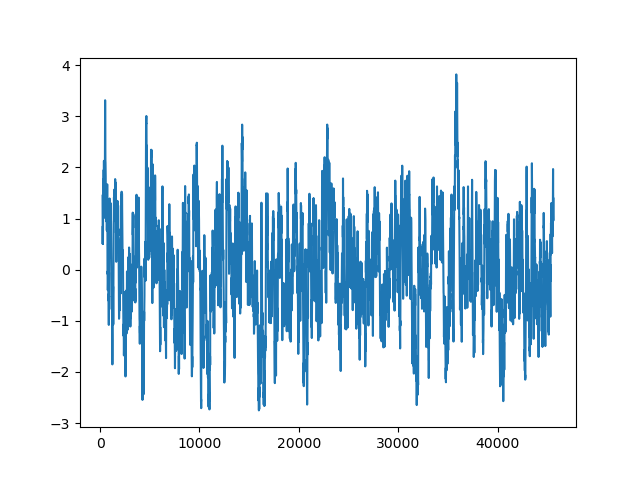

new cluster -> 0.48468825732540205
new cluster -> 1.3439083498567965


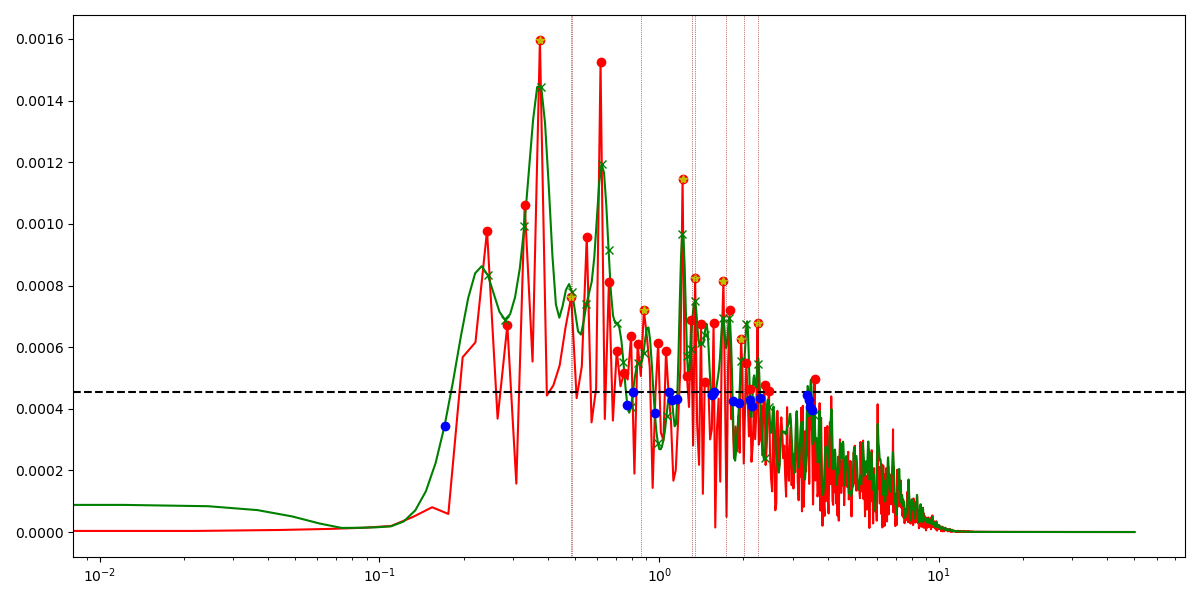

f: 0.3745318352059925 validate
f: 0.48468825732540205 validate
f: 0.8812513769552764 validate
f: 1.211720643313505 validate
f: 1.3439083498567965 validate
f: 1.6964089006389071 validate
f: 1.9607843137254901 validate
f: 2.2471910112359548 validate


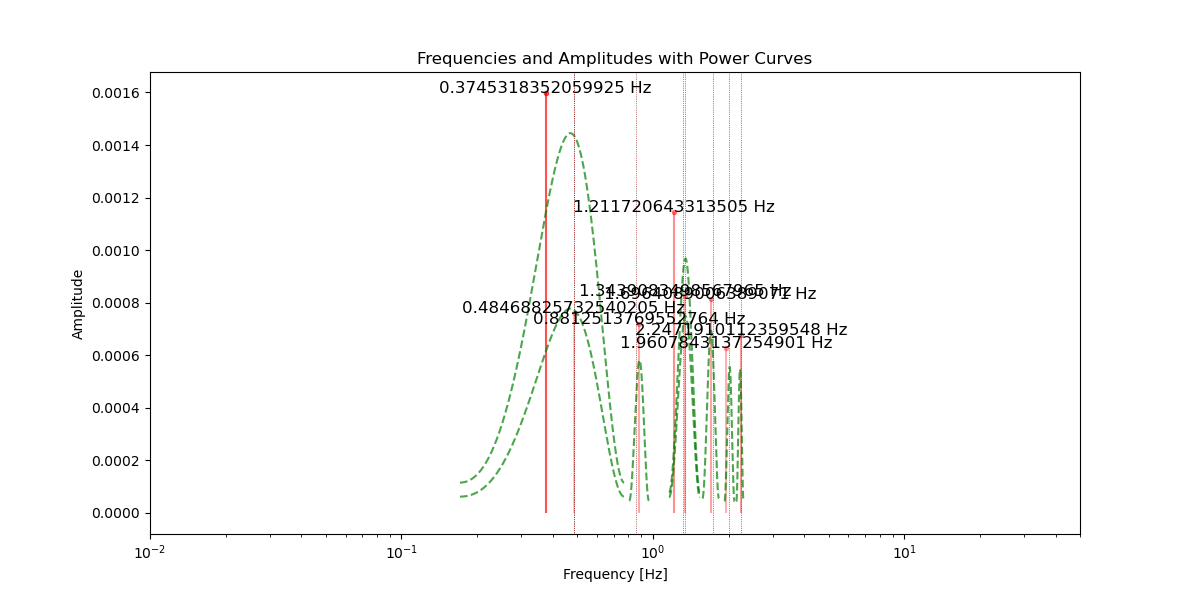

   frequency  amplitude     power                          range  centroid  \
0   0.374532   0.001598  0.001445  [0.1708984375, 0.76904296875]  0.486765   
1   0.484688   0.000763  0.000778  [0.1708984375, 0.76904296875]  0.484688   
2   0.881251   0.000720  0.000581  [0.8056640625, 0.96435546875]  0.860539   
3   1.211721   0.001145  0.000968  [1.15966796875, 1.5380859375]  1.313791   
4   1.343908   0.000825  0.000749  [1.15966796875, 1.5380859375]  1.343908   
5   1.696409   0.000815  0.000694  [1.57470703125, 1.8310546875]  1.739606   
6   1.960784   0.000627  0.000556  [1.9287109375, 2.11181640625]  2.002182   
7   2.247191   0.000677  0.000547       [2.1484375, 2.294921875]  2.247191   

     weight  
0  0.687500  
1  0.238095  
2  0.333333  
3  0.444444  
4  0.333333  
5  0.355263  
6  0.306818  
7  0.396040  
onset frequency 1.1691052253158045
untouched signal


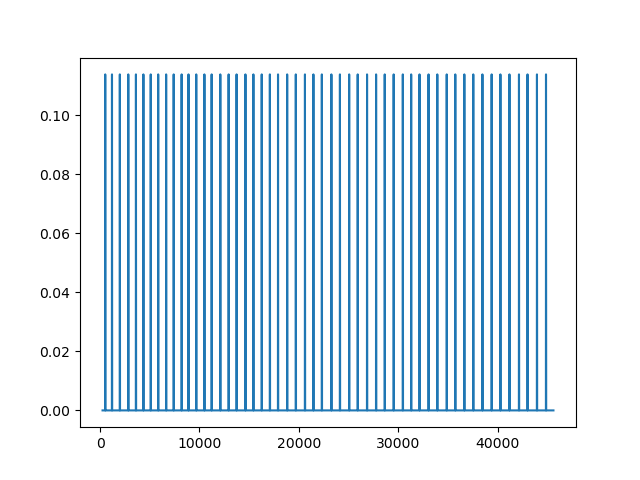

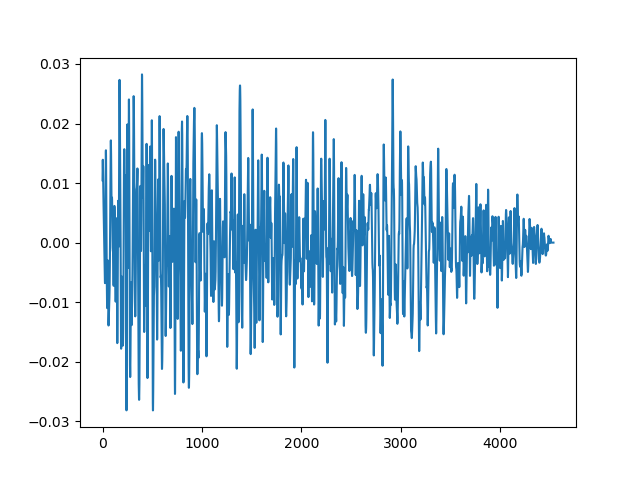

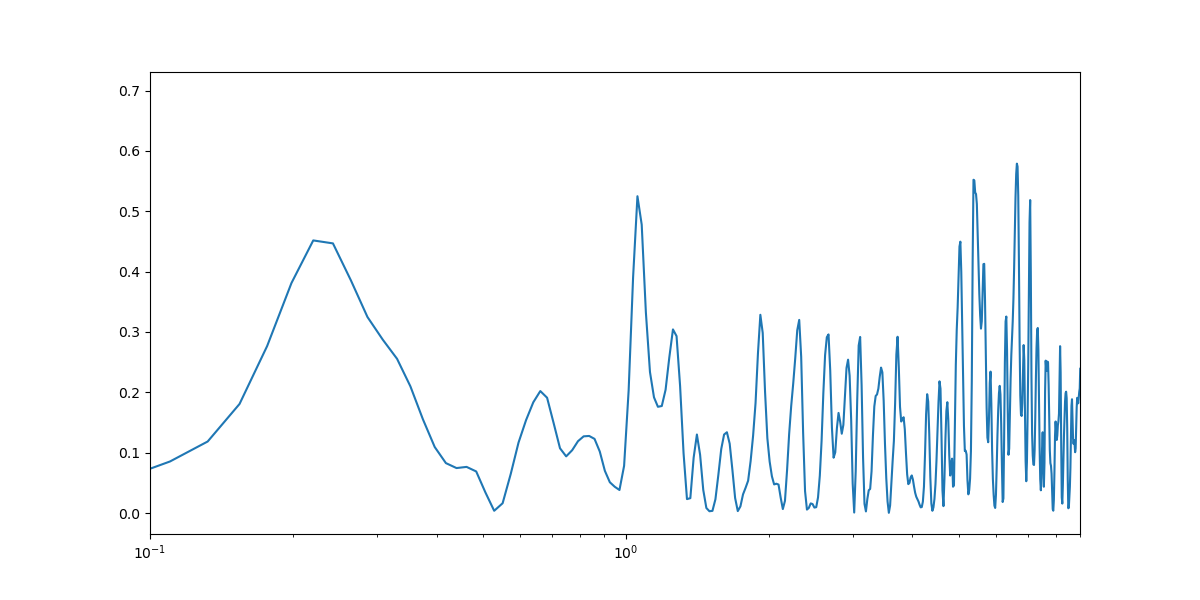

apodized onset


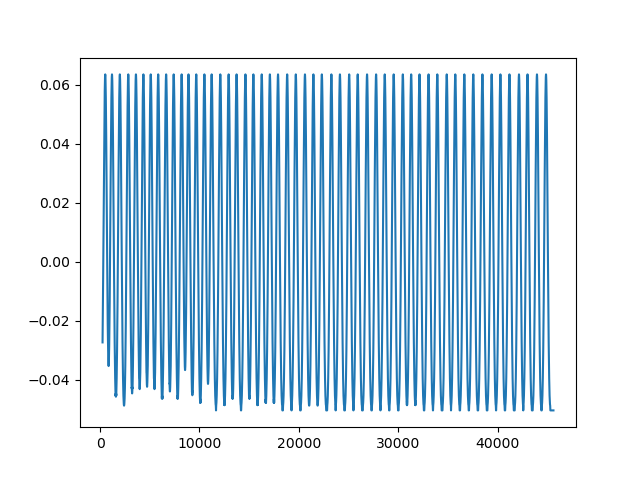

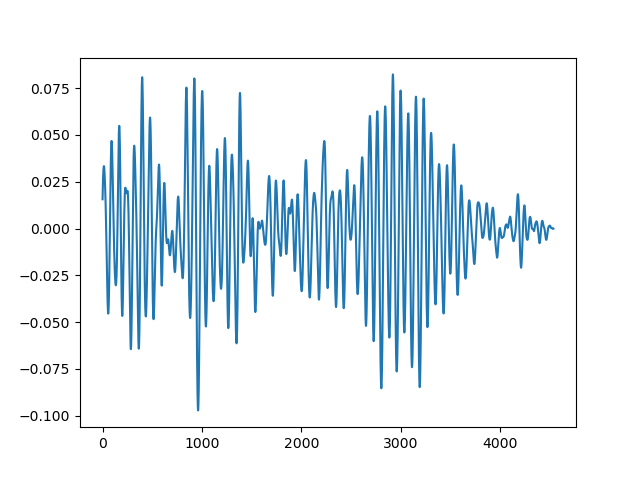

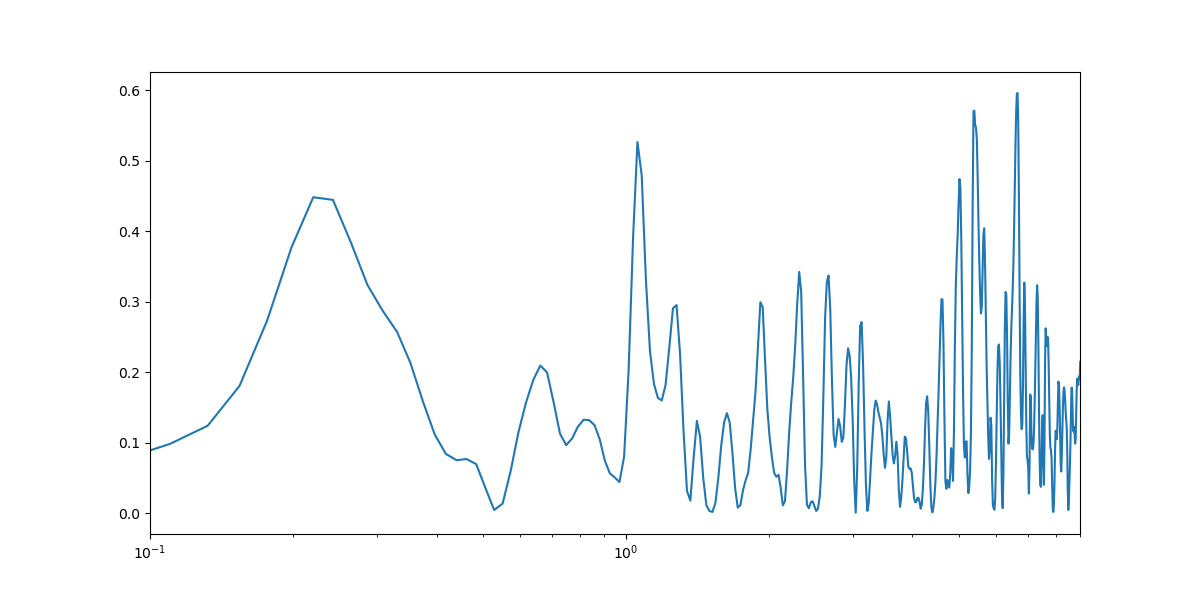

pure sinus onset


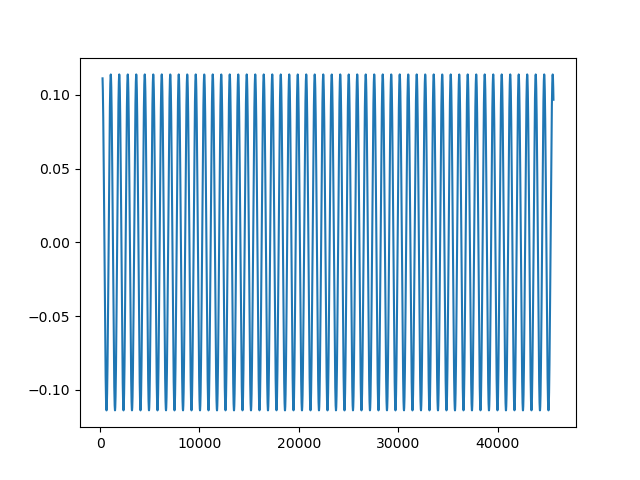

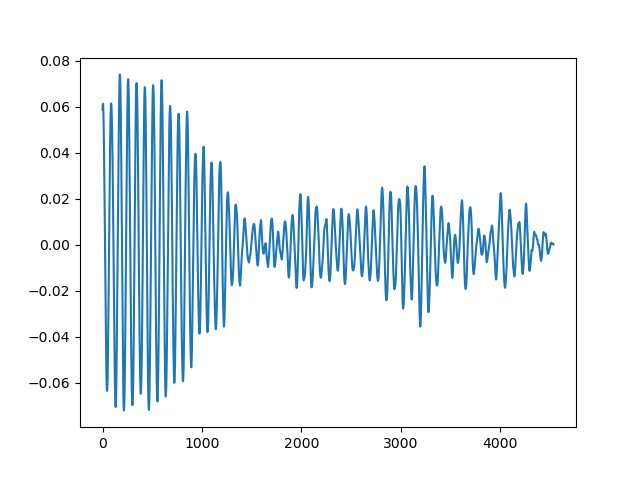

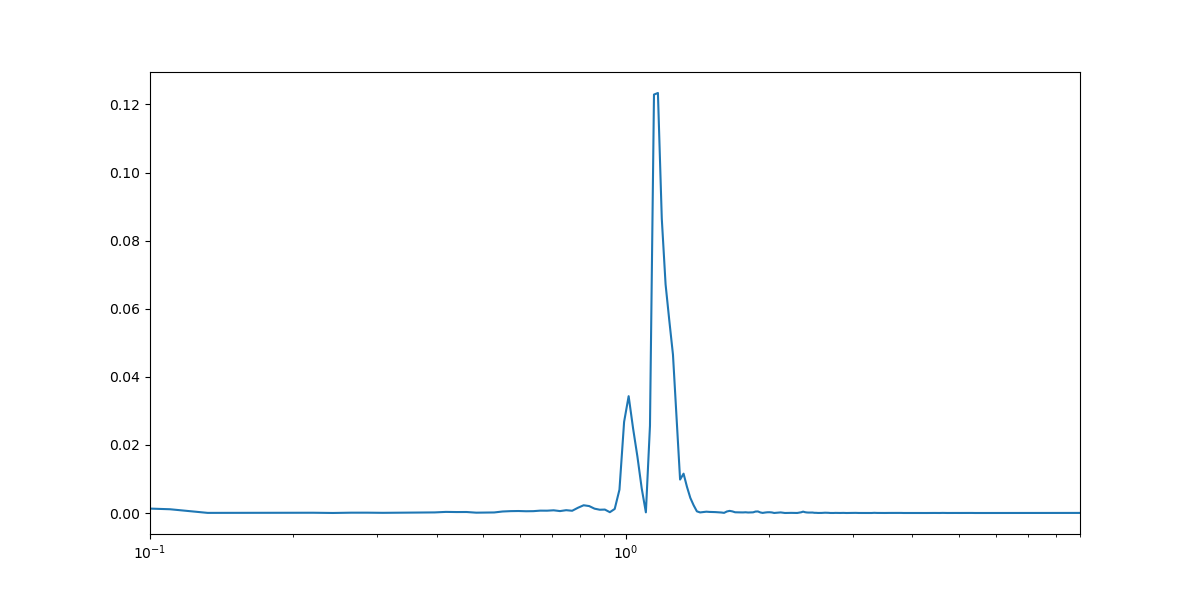

sinus convolved onset


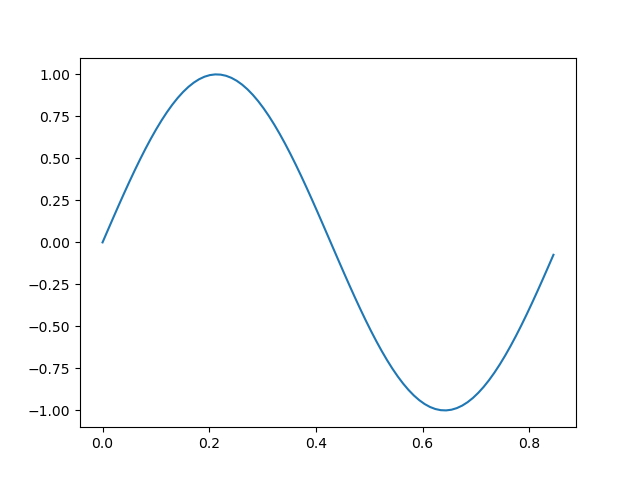

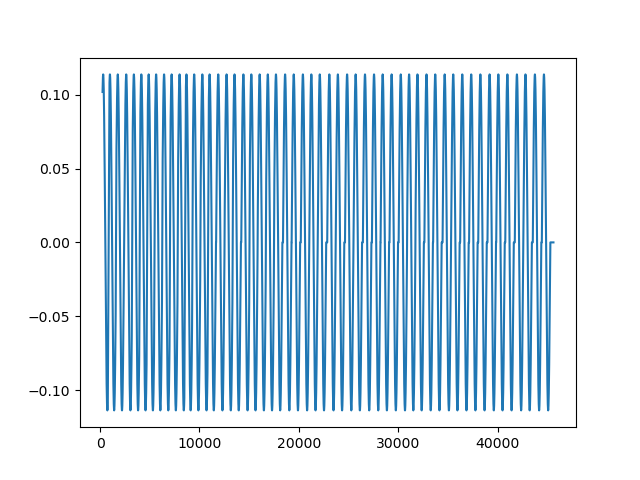

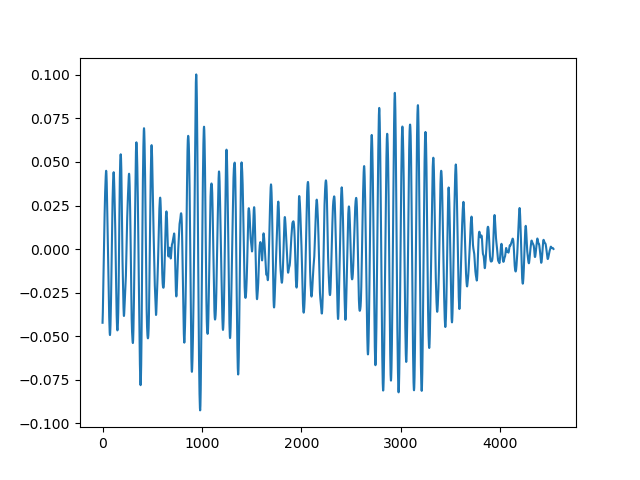

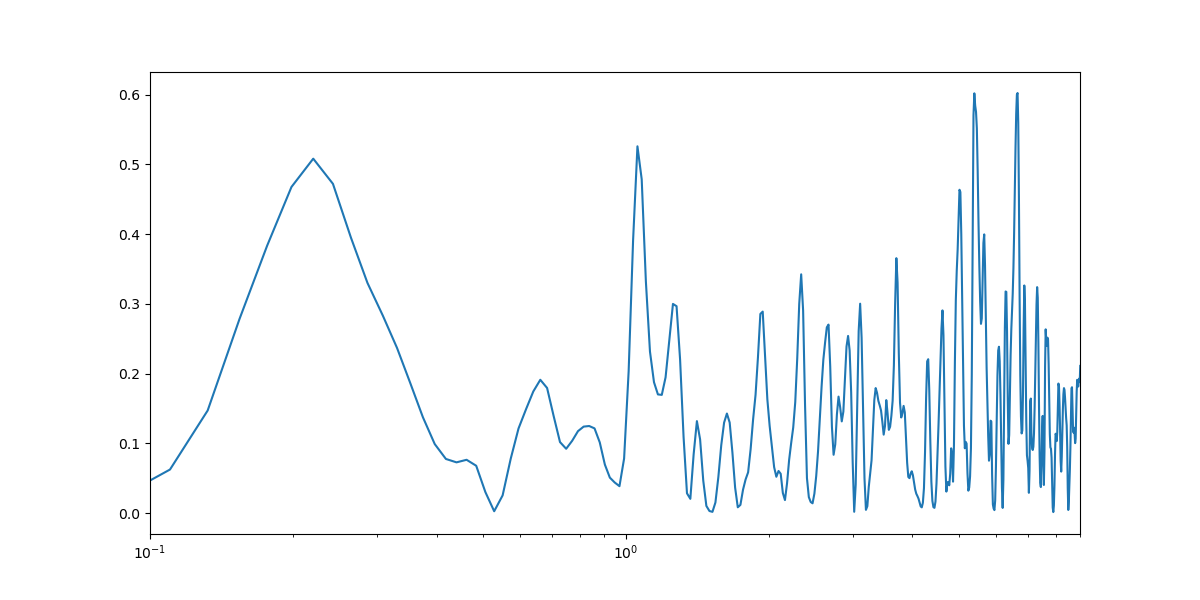

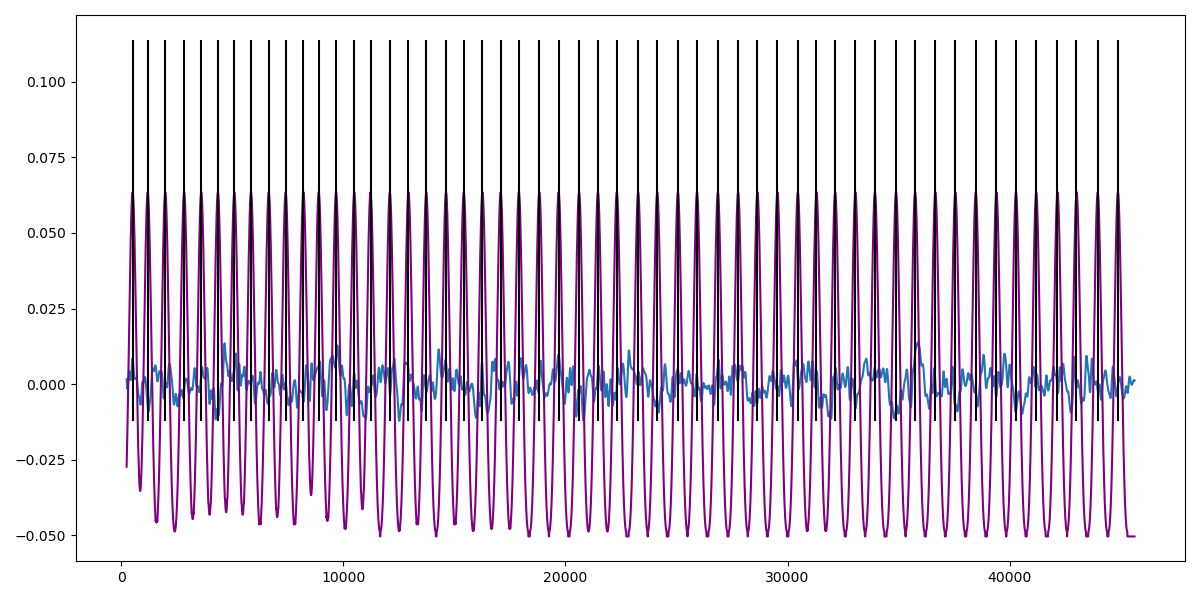

In [171]:
%matplotlib widget
from utils import ConvertContinueToBinary


plt.close('all')

musician = 'Clarinet'
riot_type = 'head'
trial = 13
data = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_intensity.csv'))
onset = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_onset.csv'))

sig_df = get_data(data,riot_type=riot_type,musician=musician,trial_n=trial).copy()
# sig_df = get_data(data,riot_n=8,trial_n=trial).copy()
onset_df = get_data(onset,musician=musician,trial_n=trial).copy()

if onset_df.size == 0:
    print('WARNING : No Onset')

sig_motion = sig_df['intensity'].to_numpy()
t = sig_df['t'].to_numpy()
_onset = onset_df['onsets'].to_numpy() 


# fig, ax = plt.subplots( figsize=(12, 6))
# plot_signal(t,sig_motion,ax=ax)
# # ax.vlines(_onset,ymin=min(sig_motion), ymax=max(sig_motion)+ 0.1,color='red')
# plot_signal(t,sig_onset,ax=ax,color='purple')
# plt.tight_layout()
# plt.show()

test = ConvertContinueToBinary.ConvertContinueToBinary(pd.DataFrame(zscore(sig_df['intensity'].to_numpy())))
plot_signal(sig_df['t'],zscore(sig_df['intensity'].to_numpy()),show=True)




sig_motion = center_sig(sig_motion)
sos = sos_butter_bandpass(0.2, 8.5)
sig_motion = sos_filter(sig_motion, sos)
# sig_motion = shift(sig_motion,-500,0)

sig_onset = onset_to_sig(onset_df,t,value=max(sig_motion)+ 0.1)
tempo : float = float(calculate_tempo(onset_df,window_size=8,bpm=False)[0])



sig_onset_apodize = center_sig(apodize(sig_onset,tempo/1000,fs=100))

hints = pd.DataFrame.from_records(advanced_cfd_autoperiod(sig_motion,iter_perm=10000,adjust_treshold=10000,tolerance=0.1,w_threshold_rate=0.1,psd_window_type='hamming',debug=True))
onset_frequency = period_to_frequency(tempo/1000)
print(hints)
print( 'onset frequency',onset_frequency)

print('untouched signal')

plot_signal(t,sig_onset,show=True)

coherence_result = signal.coherence(sig_motion,sig_onset,fs=100,nperseg=2048,noverlap=2047,window='flattop',nfft=sig_motion.size)
correlation_result = correlation(sig_motion,sig_onset)
plot_signal(*correlation_result,show=True)
fig, ax = plt.subplots( figsize=(12, 6))
plot_signal(*coherence_result,ax=ax)
ax.set_xlim(0.1,9)
ax.set_xscale('log')
plt.show()

print('apodized onset')

plot_signal(t,sig_onset_apodize,show=True)

coherence_result = signal.coherence(sig_motion,sig_onset_apodize,fs=100,nperseg=2048,noverlap=2047,window='flattop',nfft=sig_motion.size)
correlation_result = correlation(sig_motion,sig_onset_apodize)
plot_signal(*correlation_result,show=True)
fig, ax = plt.subplots( figsize=(12, 6))
plot_signal(*coherence_result,ax=ax)
ax.set_xlim(0.1,9)
ax.set_xscale('log')
plt.show()


print('pure sinus onset')
# Create the sinusoidal signal
sine_onset =  (max(sig_motion)+ 0.1) * np.sin(2 * np.pi * onset_frequency * t/1000  )
plot_signal(t,sine_onset,show=True)

coherence_result = signal.coherence(sig_motion,sine_onset,fs=100,nperseg=2048,noverlap=2047,window='hamming',nfft=sig_motion.size)
correlation_result = correlation(sig_motion,sine_onset)
plot_signal(*correlation_result,show=True)

fig, ax = plt.subplots( figsize=(12, 6))
plot_signal(*coherence_result,ax=ax)
ax.set_xlim(0.1,9)
ax.set_xscale('log')
plt.show()

print('sinus convolved onset')

sinus_t = np.linspace(0, 1.0/onset_frequency, int(100 * 1.0/onset_frequency), endpoint=False)
sinus =   shift(np.sin(2 * np.pi * onset_frequency * sinus_t ),0 ,0)

plot_signal(sinus_t,sinus,show=True)
sig_onset_sinuzed = np.convolve(sig_onset, sinus, mode='same')
plot_signal(t,sig_onset_sinuzed,show=True)

coherence_result = signal.coherence(sig_motion,sig_onset_sinuzed,fs=100,nperseg=2048,noverlap=2047,window='flattop',nfft=sig_motion.size)
correlation_result = correlation(sig_motion,sig_onset_sinuzed)
plot_signal(*correlation_result,show=True)


fig, ax = plt.subplots( figsize=(12, 6))
plot_signal(*coherence_result,ax=ax)
ax.set_xlim(0.1,9)
ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots( figsize=(12, 6))
plot_signal(t,sig_motion,ax=ax)
plot_signal(t,sig_onset_apodize,ax=ax,color='purple')
# plot_signal(t,sine_onset,ax=ax,color='red')
# plot_signal(t,sig_onset_sinuzed,ax=ax,color='green')
ax.vlines(_onset,ymin=min(sig_motion), ymax=max(sig_motion)+ 0.1,color='black')
plt.tight_layout()
plt.show()

# coherence_result = signal.coherence(sig_motion,sig_onset,fs=100,nperseg=2048,noverlap=2047,nfft=sig_motion.size)

# fig, ax = plt.subplots( figsize=(12, 6))
# plot_signal(*coherence_result,ax=ax)
# ax.set_xlim(0.1,9)
# ax.set_xscale('log')
# plt.show()



In [ ]:
data = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_intensity.csv'))
onset = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_onset.csv'))

plt.close('all')

n=0

for k,df in dataset.iterate_df('sig','trial_n','riot_n'):

    if(n==20): break

    df.reset_index(drop=True,inplace=True)
    if df['riot_type'][0] == 'leg': continue

    print(k[0],df['musician'][0],df['riot_type'][0])

    sig_motion = df['intensity'].to_numpy()
    sig_motion = center_sig(sig_motion)
    sos = sos_butter_bandpass(0.3, 8.5)
    sig_motion = sos_filter(sig_motion, sos)

    advanced_cfd_autoperiod(sig_motion,iter_perm=1000,adjust_treshold=750,debug=True)

    n+=1

Feature Extraction: 100%|██████████| 20/20 [04:26<00:00, 13.34s/it]
c:\Users\haron\miniconda3\envs\analyse_dsync\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


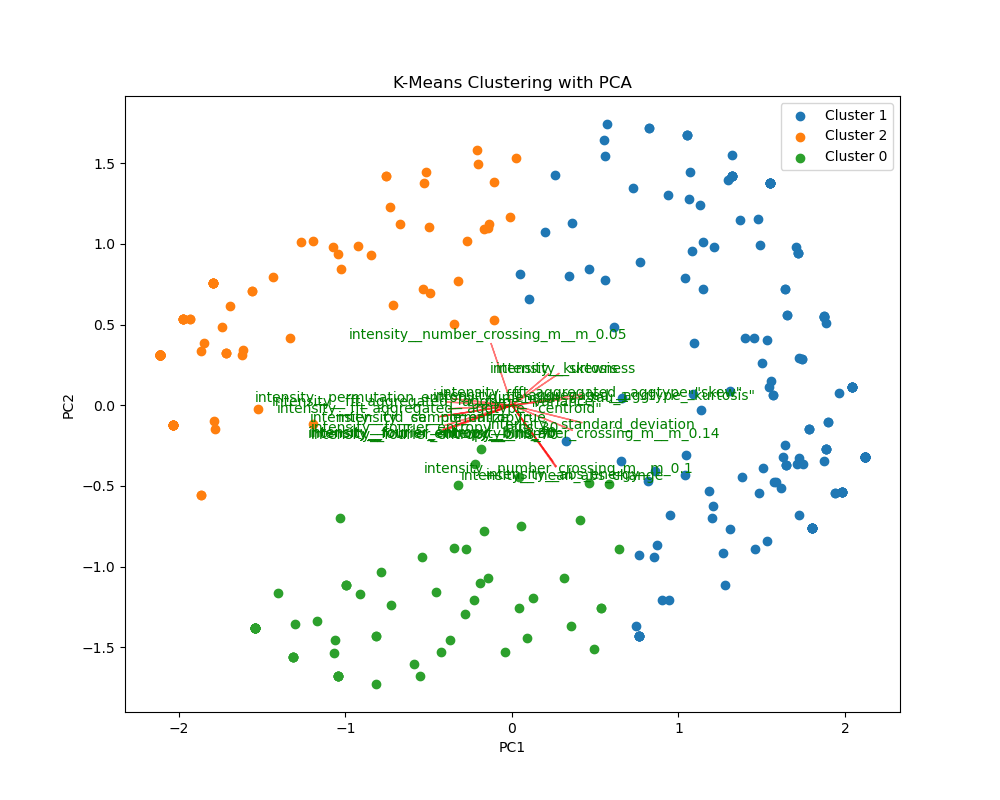

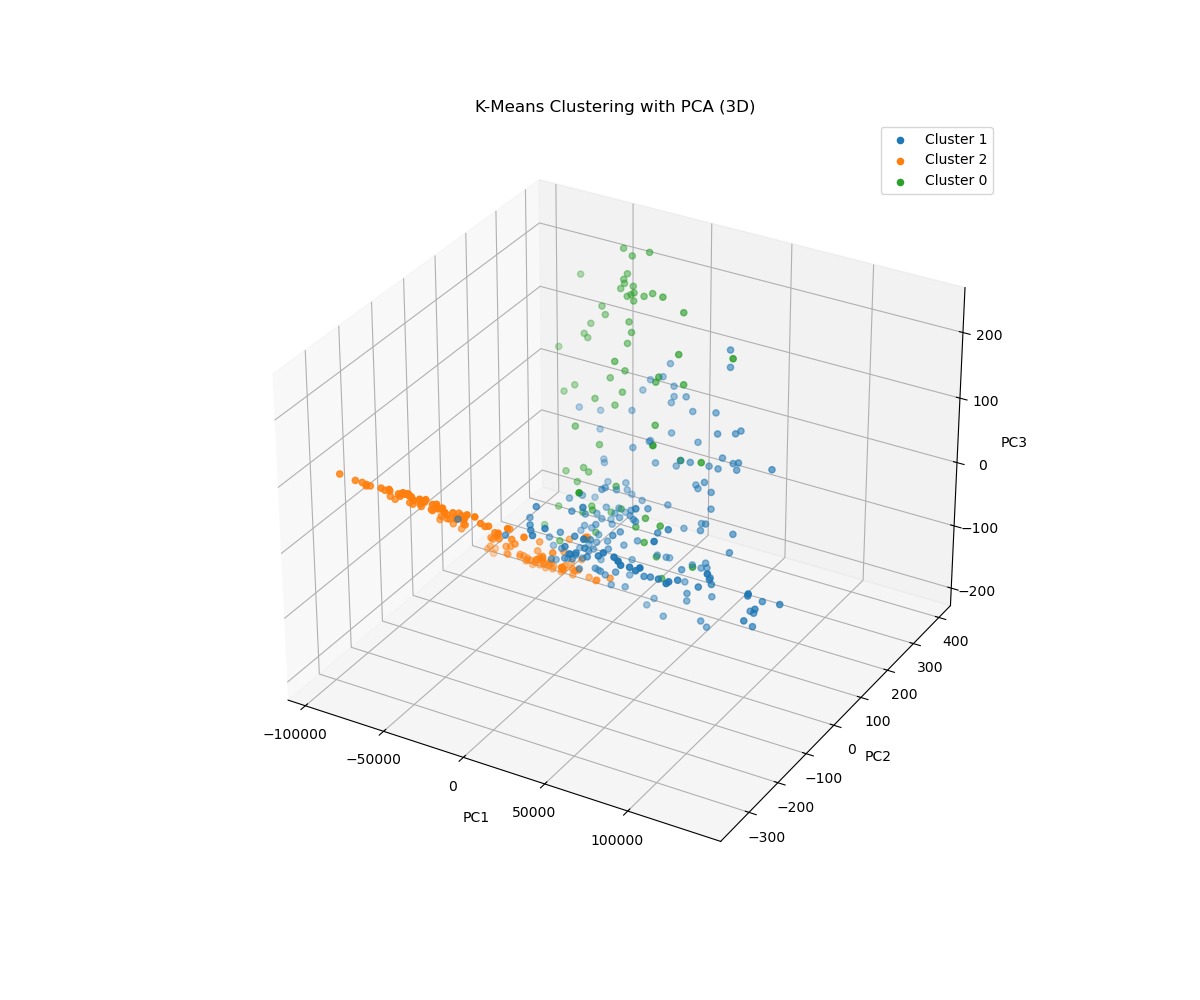

Labels générés:
10_1     1
10_10    1
10_11    2
10_12    0
10_2     1
        ..
9_5      1
9_6      1
9_7      2
9_8      1
9_9      2
Name: label, Length: 384, dtype: int32
Relevance Table:
                                                                                              feature  \
feature                                                                                                 
intensity__cid_ce__normalize_True                                   intensity__cid_ce__normalize_True   
intensity__sample_entropy                                                   intensity__sample_entropy   
intensity__fft_aggregated__aggtype_"kurtosis"           intensity__fft_aggregated__aggtype_"kurtosis"   
intensity__fft_aggregated__aggtype_"skew"                   intensity__fft_aggregated__aggtype_"skew"   
intensity__standard_deviation                                           intensity__standard_deviation   
intensity__fourier_entropy__bins_50                               intens

In [5]:
#testing tsfresh to extract features and select relavant one
%matplotlib widget
plt.close('all')

from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

custom_fc_parameters = {
    # variabilité en frq
    'fft_aggregated': [{'aggtype': 'centroid'},{'aggtype': 'kurtosis'},{'aggtype': 'variance'},{'aggtype': 'skew'}],
    'fourier_entropy': [{'bins': 30},{'bins': 50},{'bins': 40},{'bins': 70}],
    # variabilité en amp
    # 'variance': None,
    'standard_deviation': None,
    'mean_abs_change': None,
    # noise rate
    'kurtosis': None,
    'skewness': None,
    'cid_ce': [{'normalize': True}],
    # noise amp
    'abs_energy': None,
    'number_crossing_m': [{'m': 0.05},{'m': 0.1},{'m': 0.14}],

    # fiability of periodicity
    'sample_entropy': None,
    'permutation_entropy': [
        # {'tau': 1, 'dimension': 4},
        # {'tau': 1, 'dimension': 5},
        # {'tau': 1, 'dimension': 6},
        {'tau': 1, 'dimension': 7},
        # {'tau': 2, 'dimension': 5},
        # {'tau': 2, 'dimension': 6},
        # {'tau': 2, 'dimension': 7},
        # {'tau': 5, 'dimension': 7},
    ]
}

data = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_intensity.csv'))
onset = pd.read_csv(os.path.join(MAIN_DATA_FOLDER,'csv/click_tempo_onset.csv'))

data['id'] = data['trial_n'].astype(str) + '_' + data['riot_n'].astype(str)

extracted_features = extract_features(data, column_id="id", column_sort="t",column_value='intensity',default_fc_parameters=custom_fc_parameters)

extracted_features_imputed = extracted_features.fillna(extracted_features.mean())
extracted_features_imputed = extracted_features_imputed.dropna(axis=1, how='all')

def binarize_feature(feature):
    median_value = np.median(feature)
    return (feature > median_value).astype(int)

binarized_features = extracted_features_imputed.apply(binarize_feature, axis=0)

# Appliquer K-Means pour créer des clusters (par exemple, 2 clusters)
kmeans = KMeans(n_clusters=3, random_state=0,max_iter=3000).fit(binarized_features)

# Les labels générés par K-Means
labels = kmeans.labels_
# extracted_features_imputed['label'] = labels

# Réduction de la dimensionnalité à 2D
pca = PCA(n_components=2)
components = pca.fit_transform(binarized_features)
# components = pca.fit_transform(extracted_features_imputed.drop(columns=['label']))

# DataFrame des composantes principales
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['label'] = labels

# Tracer les résultats
plt.figure(figsize=(10, 8))
for label in pca_df['label'].unique():
    plt.scatter(pca_df[pca_df['label'] == label]['PC1'], pca_df[pca_df['label'] == label]['PC2'], label=f'Cluster {label}')
# Plot des vecteurs des caractéristiques
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(binarized_features.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='r', alpha=0.5)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, feature, color='g', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering with PCA')
plt.legend()
plt.show()

# Réduction de la dimensionnalité à 3D avec PCA
pca = PCA(n_components=3)
components = pca.fit_transform(extracted_features_imputed)

# DataFrame des composantes principales
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = labels

# Tracer les résultats en 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for label in pca_df['label'].unique():
    indices = pca_df['label'] == label
    ax.scatter(pca_df.loc[indices, 'PC1'], pca_df.loc[indices, 'PC2'], pca_df.loc[indices, 'PC3'], label=f'Cluster {label}')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('K-Means Clustering with PCA (3D)')
ax.legend()
plt.show()

# Créer le DataFrame y avec les labels générés
y = pd.Series(labels, index=extracted_features_imputed.index, name='label')
print("Labels générés:")
print(y)

# Calculate relevance
relevance_table = calculate_relevance_table(extracted_features_imputed, y)
print("Relevance Table:")
print(relevance_table)

# Select relevant features
selected_features = select_features(extracted_features_imputed, y)
print("Selected Features:")
print(selected_features)

In [ ]:
plt.figure()
sns.scatterplot(selected_features,x='intensity__fourier_entropy__bins_70',y='intensity__fft_aggregated__aggtype_"variance"')
plt.show()
# sns.scatterplot(selected_features,y='intensity__approximate_entropy__m_2__r_0.1',x='intensity__permutation_entropy__dimension_4__tau_1')
# plt.show()

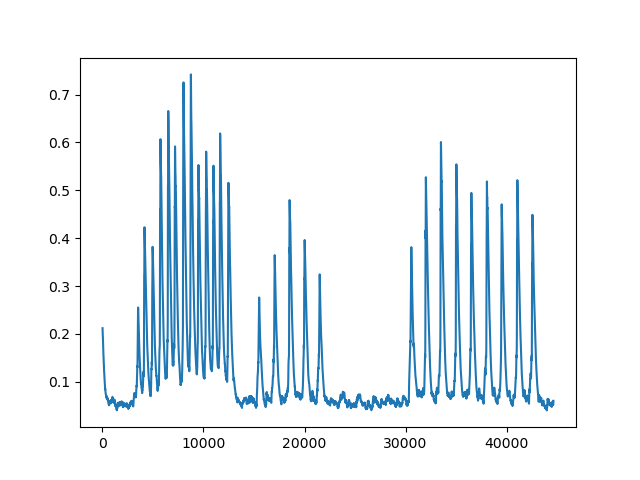

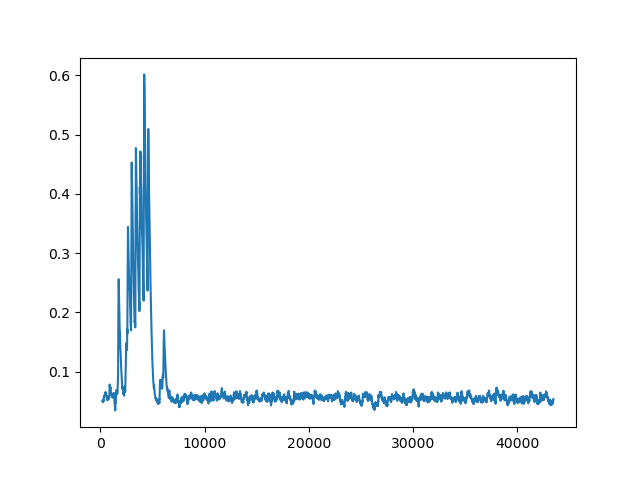

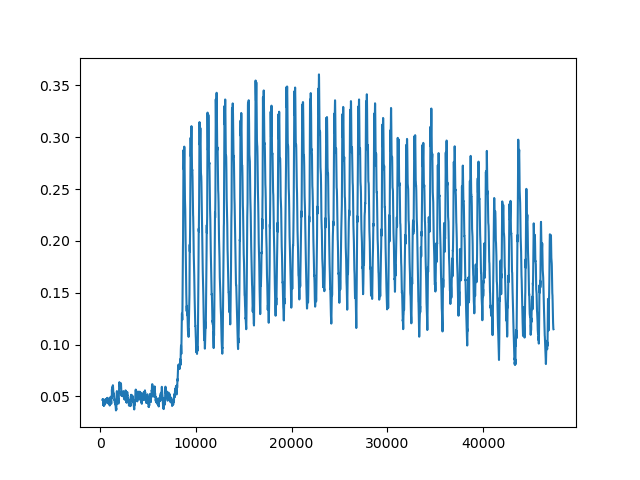

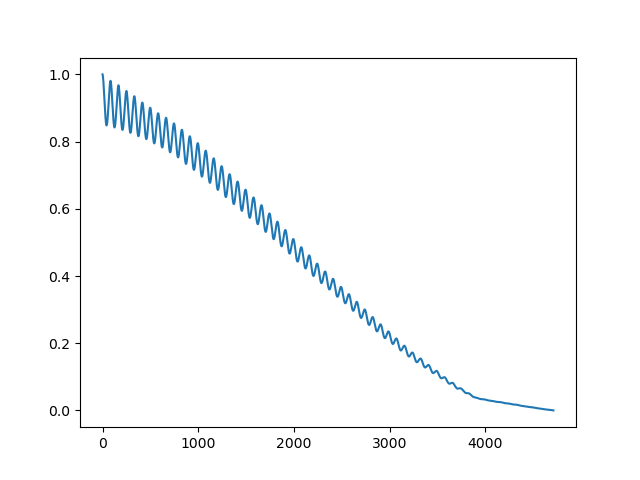

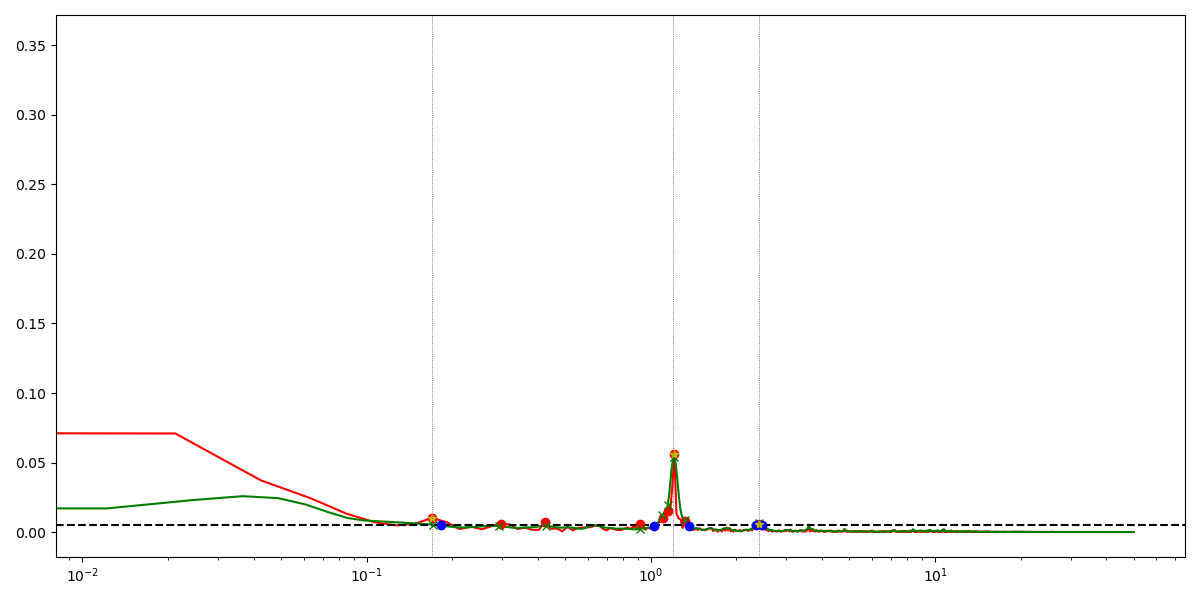

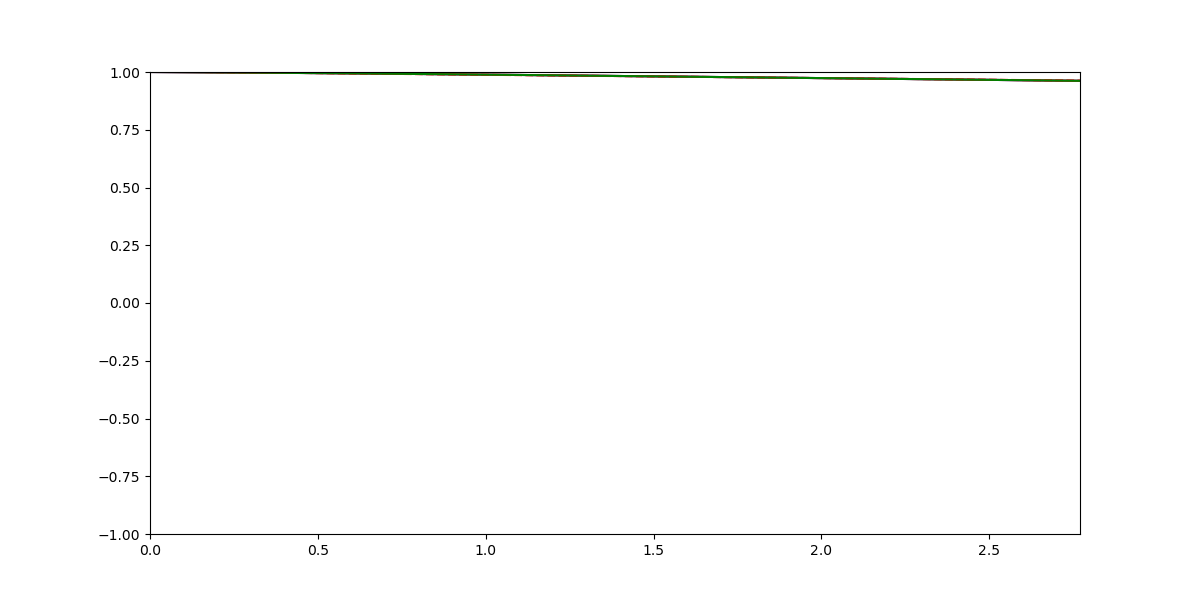

range [55.955, 61.845]


TypeError: expected non-empty vector for x

In [43]:
s = get_data(data,trial_n=10,riot_n=6)

plot_signal(s['t'],s['intensity'],show=True)
s = get_data(data,trial_n=14,riot_n=6)

plot_signal(s['t'],s['intensity'],show=True)
s = get_data(data,trial_n=15,riot_n=8)

plot_signal(s['t'],s['intensity'],show=True)
sig = s['intensity'].to_numpy()
autoc = autocorrelation(sig)
plot_signal(*autoc,show=True)

advanced_cfd_autoperiod(sig,debug=True)

s = get_data(data,trial_n=19,riot_n=1)

plot_signal(s['t'],s['intensity'],show=True)
sig = s['intensity'].to_numpy()
autoc = autocorrelation(sig)
plot_signal(*autoc,show=True)

advanced_cfd_autoperiod(sig,debug=True)



s = get_data(data,trial_n=2,riot_n=8)
plot_signal(s['t'],s['intensity'],show=True)
sig = s['intensity'].to_numpy()
autoc = autocorrelation(sig)
plot_signal(*autoc,show=True)
advanced_cfd_autoperiod(sig,debug=True)

# s = get_data(data,trial_n=11,riot_n=9)
# plot_signal(s['t'],s['intensity'],show=True)
# sig = s['intensity'].to_numpy()
# autoc = autocorrelation(sig)
# plot_signal(*autoc,show=True)
# advanced_cfd_autoperiod(sig,debug=True)

s = get_data(data,trial_n=28,riot_n=6)
plot_signal(s['t'],s['intensity'],show=True)
sig = s['intensity'].to_numpy()
autoc = autocorrelation(sig)
plot_signal(*autoc,show=True)
advanced_cfd_autoperiod(sig,debug=True)


s = get_data(data,trial_n=2,riot_n=11)
plot_signal(s['t'],s['intensity'],show=True)
sig = s['intensity'].to_numpy()
autoc = autocorrelation(sig)
plot_signal(*autoc,show=True)
advanced_cfd_autoperiod(sig,debug=True)

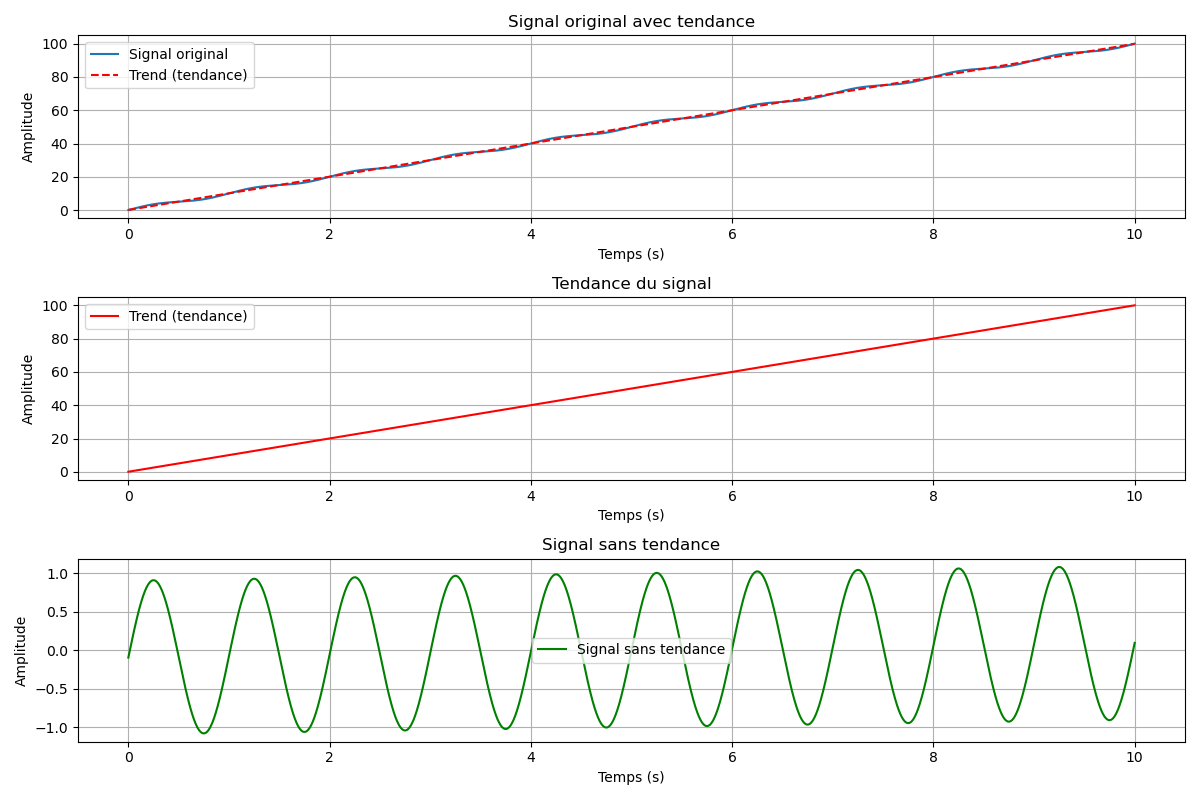

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres du signal
sampling_rate = 1000  # Hz
duration = 10  # secondes
t = np.linspace(0, duration, duration * sampling_rate)

# Composante oscillatoire à 1 Hz
frequency = 1  # Hz
oscillatory_component = np.sin(2 * np.pi * frequency * t)

# Composante linéaire très forte
linear_component = 10 * t

# Signal résultant
signal = oscillatory_component + linear_component

# Calcul de la tendance avec polyfit
trend_coefficients = np.polyfit(t, signal, 1)  # Ajustement d'une ligne droite (polynôme de degré 1)
trend = np.polyval(trend_coefficients, t)

# Soustraction de la tendance du signal
detrended_signal = signal - trend

# Tracé des résultats
plt.figure(figsize=(12, 8))

# Tracé du signal original
plt.subplot(3, 1, 1)
plt.plot(t, signal, label='Signal original')
plt.plot(t, trend, label='Trend (tendance)', linestyle='--', color='red')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal original avec tendance')
plt.legend()
plt.grid(True)

# Tracé de la tendance
plt.subplot(3, 1, 2)
plt.plot(t, trend, label='Trend (tendance)', color='red')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Tendance du signal')
plt.legend()
plt.grid(True)

# Tracé du signal sans la tendance
plt.subplot(3, 1, 3)
plt.plot(t, detrended_signal, label='Signal sans tendance', color='green')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal sans tendance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()